In [14]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from datetime import datetime, timedelta

import operator

import mpmath as mp
from importlib import reload

from utils import utils, net_lstm, net_lstm_w2v
from tqdm import tqdm
import random
sns.set(style="whitegrid")


torch.manual_seed(1)

In [15]:
# Defining the users for the different data sets and loading the data
reload(utils)
# Getting a list of valid candidates given properties
pep_info = pd.read_pickle("data_inf.pkl")

pep_600 = list(pep_info[(pep_info["length"]>1000)].index)
good_peps = np.loadtxt('good_peps.txt')#,dtype=int)

train_peps = good_peps[good_peps<=600]
train_peps = np.array(list(set(train_peps).intersection(pep_600)))

train_peps_all = good_peps
train_peps_all = np.array(list(set(train_peps_all).intersection(pep_600)))

train_peps_vali = good_peps[good_peps>600]
train_peps_vali = np.array(list(set(train_peps_vali).intersection(pep_600)))

#Load data
#_, dat_test = utils.load_train_test_set(train_peps,bs=10)  # Loading validation data
dat_train_both, _ = utils.load_train_test_set(train_peps_all,bs=10) # Loading training data for all users
_, dat_test_vali = utils.load_train_test_set(train_peps_vali,bs=10) # Loading test data

In [17]:
# Creaing network
reload(net_lstm_w2v)
net = net_lstm_w2v.Brain()
net.lr = 0.001
net.bs = 10
net.seq_len=100
net.epochs = 100
net.epoch_test = 10

net.create_model()

In [18]:
# Loading previously trained weights
path = "Network/network_epoch_0.338_Feb-23-2020"
net.model.load_state_dict(torch.load(path))

In [20]:
# Predictions on the test data
res_net = net.test(dat_test_vali,True)

Test loss: 1.161 | Test accu: 0.340 | Test accu expl: 0.814 | Test expl AUC: 0.708 | 

In [23]:
np.mean(net.topk[3])

0.45867843368555833

In [24]:
np.mean(net.topk[5])

0.5013749725964309

## Transfer

In [25]:
# Extra training on every user individually
total_epoch = 12
bs_trans = 1 
epochs_trans = 2
topk = {i:{3:[],5:[]} for i in range(0,total_epoch,epochs_trans)}
dict_tmp = {i:{} for i in range(0,total_epoch,epochs_trans)}
for pep_trans in tqdm(train_peps_vali):
    
    net_trans = net_lstm_w2v.Brain()
    net_trans.create_model()
    
    net_trans.model.load_state_dict(torch.load(path))
    net_trans.bs = bs_trans
    net_trans.epochs = epochs_trans
    net_trans.seq_len=100
    
    dat_train_both_trans,dat_test_trans = utils.load_train_test_set([pep_trans])
    #dat_train_both_trans,dat_test_trans = utils.shuffle_data(dat_train_both_trans,dat_test_trans,shuffle_dict=shuffle_dict_trans)
    
    for i in range(0,total_epoch,epochs_trans):
        net_trans.train(dat_train_both_trans,dat_test_trans)
        dict_tmp[i].update(net_trans.test(dat_test_trans,True)[0])
        topk[i][3].append(np.mean(net_trans.topk[3]))
        topk[i][5].append(np.mean(net_trans.topk[5]))

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]

Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.425 | Training accu expl: 0.810 | Test loss: 0.936 | Test accu: 0.307 | Test accu expl: 0.929 | Test expl AUC: 0.752 | 
Test loss: 0.907 | Test accu: 0.323 | Test accu expl: 0.929 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.434 | Training accu: 0.446 | Training accu expl: 0.807 | Test loss: 0.894 | Test accu: 0.315 | Test accu expl: 0.929 | Test expl AUC: 0.753 | 
Test loss: 0.882 | Test accu: 0.331 | Test accu expl: 0.929 | Test expl AUC: 0.745 | Epoch: 1/2 | Avg epoch loss: 1.361 | Training accu: 0.459 | Training accu expl: 0.810 | Test loss: 0.874 | Test accu: 0.339 | Test accu expl: 0.921 | Test expl AUC: 0.742 | 
Test loss: 0.865 | Test accu: 0.346 | Test accu expl: 0.921 | Test expl AUC: 0.735 | Epoch: 1/2 | Avg epoch loss: 1.329 | Training accu: 0.471 | Training accu expl: 0.807 | Test loss: 0.842 | Test accu: 0.354 | Test accu expl: 0.921 | Test expl AUC: 0.730 | 
Test loss: 0.820 | Test accu: 0.378 | Test accu e

  1%|█                                                                                  | 1/80 [00:09<12:26,  9.45s/it]

Epoch: 1/2 | Avg epoch loss: 1.409 | Training accu: 0.544 | Training accu expl: 0.839 | Test loss: 0.938 | Test accu: 0.586 | Test accu expl: 0.879 | Test expl AUC: 0.748 | 
Test loss: 0.911 | Test accu: 0.593 | Test accu expl: 0.879 | Test expl AUC: 0.744 | Epoch: 1/2 | Avg epoch loss: 1.349 | Training accu: 0.557 | Training accu expl: 0.840 | Test loss: 0.915 | Test accu: 0.593 | Test accu expl: 0.879 | Test expl AUC: 0.730 | 
Test loss: 0.909 | Test accu: 0.586 | Test accu expl: 0.879 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.322 | Training accu: 0.558 | Training accu expl: 0.842 | Test loss: 0.901 | Test accu: 0.586 | Test accu expl: 0.871 | Test expl AUC: 0.714 | 
Test loss: 0.896 | Test accu: 0.586 | Test accu expl: 0.864 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.301 | Training accu: 0.566 | Training accu expl: 0.842 | Test loss: 0.892 | Test accu: 0.586 | Test accu expl: 0.864 | Test expl AUC: 0.709 | 
Test loss: 0.893 | Test accu: 0.586 | Test accu e

  2%|██                                                                                 | 2/80 [00:19<12:36,  9.70s/it]

Epoch: 1/2 | Avg epoch loss: 1.944 | Training accu: 0.277 | Training accu expl: 0.654 | Test loss: 0.815 | Test accu: 0.184 | Test accu expl: 0.675 | Test expl AUC: 0.470 | 
Test loss: 0.827 | Test accu: 0.175 | Test accu expl: 0.636 | Test expl AUC: 0.460 | Epoch: 1/2 | Avg epoch loss: 1.839 | Training accu: 0.292 | Training accu expl: 0.681 | Test loss: 0.821 | Test accu: 0.175 | Test accu expl: 0.680 | Test expl AUC: 0.459 | 
Test loss: 0.817 | Test accu: 0.175 | Test accu expl: 0.660 | Test expl AUC: 0.460 | Epoch: 1/2 | Avg epoch loss: 1.791 | Training accu: 0.295 | Training accu expl: 0.682 | Test loss: 0.837 | Test accu: 0.175 | Test accu expl: 0.636 | Test expl AUC: 0.459 | 
Test loss: 0.830 | Test accu: 0.175 | Test accu expl: 0.655 | Test expl AUC: 0.461 | Epoch: 1/2 | Avg epoch loss: 1.721 | Training accu: 0.297 | Training accu expl: 0.689 | Test loss: 0.847 | Test accu: 0.175 | Test accu expl: 0.655 | Test expl AUC: 0.463 | 
Test loss: 0.854 | Test accu: 0.175 | Test accu e

  4%|███                                                                                | 3/80 [00:35<14:36, 11.38s/it]

Epoch: 1/2 | Avg epoch loss: 1.213 | Training accu: 0.502 | Training accu expl: 0.882 | Test loss: 1.262 | Test accu: 0.353 | Test accu expl: 0.950 | Test expl AUC: 0.668 | 
Test loss: 1.306 | Test accu: 0.362 | Test accu expl: 0.947 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.161 | Training accu: 0.505 | Training accu expl: 0.881 | Test loss: 1.251 | Test accu: 0.353 | Test accu expl: 0.947 | Test expl AUC: 0.666 | 
Test loss: 1.215 | Test accu: 0.356 | Test accu expl: 0.947 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.187 | Training accu: 0.487 | Training accu expl: 0.883 | Test loss: 1.264 | Test accu: 0.359 | Test accu expl: 0.947 | Test expl AUC: 0.663 | 
Test loss: 1.213 | Test accu: 0.359 | Test accu expl: 0.947 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.110 | Training accu: 0.505 | Training accu expl: 0.882 | Test loss: 1.247 | Test accu: 0.362 | Test accu expl: 0.947 | Test expl AUC: 0.666 | 
Test loss: 1.231 | Test accu: 0.362 | Test accu e

  5%|████▏                                                                              | 4/80 [00:58<19:01, 15.01s/it]

Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.436 | Training accu expl: 0.819 | Test loss: 0.877 | Test accu: 0.267 | Test accu expl: 0.867 | Test expl AUC: 0.797 | 
Test loss: 0.867 | Test accu: 0.276 | Test accu expl: 0.857 | Test expl AUC: 0.798 | Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.459 | Training accu expl: 0.832 | Test loss: 0.866 | Test accu: 0.276 | Test accu expl: 0.848 | Test expl AUC: 0.803 | 
Test loss: 0.864 | Test accu: 0.286 | Test accu expl: 0.838 | Test expl AUC: 0.803 | Epoch: 1/2 | Avg epoch loss: 1.367 | Training accu: 0.469 | Training accu expl: 0.842 | Test loss: 0.870 | Test accu: 0.295 | Test accu expl: 0.848 | Test expl AUC: 0.806 | 
Test loss: 0.867 | Test accu: 0.305 | Test accu expl: 0.848 | Test expl AUC: 0.804 | Epoch: 1/2 | Avg epoch loss: 1.311 | Training accu: 0.478 | Training accu expl: 0.835 | Test loss: 0.864 | Test accu: 0.295 | Test accu expl: 0.848 | Test expl AUC: 0.805 | 
Test loss: 0.871 | Test accu: 0.295 | Test accu e

  6%|█████▏                                                                             | 5/80 [01:06<16:08, 12.91s/it]

Epoch: 1/2 | Avg epoch loss: 1.690 | Training accu: 0.381 | Training accu expl: 0.834 | Test loss: 0.856 | Test accu: 0.522 | Test accu expl: 0.897 | Test expl AUC: 0.595 | 
Test loss: 0.849 | Test accu: 0.526 | Test accu expl: 0.885 | Test expl AUC: 0.594 | Epoch: 1/2 | Avg epoch loss: 1.577 | Training accu: 0.397 | Training accu expl: 0.836 | Test loss: 0.827 | Test accu: 0.530 | Test accu expl: 0.893 | Test expl AUC: 0.602 | 
Test loss: 0.820 | Test accu: 0.526 | Test accu expl: 0.893 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.543 | Training accu: 0.406 | Training accu expl: 0.833 | Test loss: 0.806 | Test accu: 0.526 | Test accu expl: 0.893 | Test expl AUC: 0.609 | 
Test loss: 0.805 | Test accu: 0.526 | Test accu expl: 0.893 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.506 | Training accu: 0.411 | Training accu expl: 0.845 | Test loss: 0.809 | Test accu: 0.526 | Test accu expl: 0.893 | Test expl AUC: 0.609 | 
Test loss: 0.811 | Test accu: 0.530 | Test accu e

  8%|██████▏                                                                            | 6/80 [01:24<17:49, 14.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.991 | Training accu: 0.266 | Training accu expl: 0.790 | Test loss: 1.132 | Test accu: 0.229 | Test accu expl: 0.761 | Test expl AUC: 0.725 | 
Test loss: 1.120 | Test accu: 0.239 | Test accu expl: 0.761 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.831 | Training accu: 0.280 | Training accu expl: 0.794 | Test loss: 1.070 | Test accu: 0.229 | Test accu expl: 0.761 | Test expl AUC: 0.722 | 
Test loss: 1.049 | Test accu: 0.234 | Test accu expl: 0.761 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.822 | Training accu: 0.300 | Training accu expl: 0.799 | Test loss: 1.044 | Test accu: 0.234 | Test accu expl: 0.761 | Test expl AUC: 0.723 | 
Test loss: 1.012 | Test accu: 0.239 | Test accu expl: 0.766 | Test expl AUC: 0.723 | Epoch: 1/2 | Avg epoch loss: 1.735 | Training accu: 0.306 | Training accu expl: 0.794 | Test loss: 1.002 | Test accu: 0.239 | Test accu expl: 0.757 | Test expl AUC: 0.725 | 
Test loss: 1.006 | Test accu: 0.239 | Test accu e

  9%|███████▎                                                                           | 7/80 [01:40<18:03, 14.84s/it]

Epoch: 1/2 | Avg epoch loss: 1.350 | Training accu: 0.416 | Training accu expl: 0.767 | Test loss: 0.981 | Test accu: 0.406 | Test accu expl: 0.787 | Test expl AUC: 0.735 | 
Test loss: 0.975 | Test accu: 0.399 | Test accu expl: 0.776 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.258 | Training accu: 0.434 | Training accu expl: 0.769 | Test loss: 0.992 | Test accu: 0.399 | Test accu expl: 0.783 | Test expl AUC: 0.721 | 
Test loss: 0.951 | Test accu: 0.406 | Test accu expl: 0.773 | Test expl AUC: 0.717 | Epoch: 1/2 | Avg epoch loss: 1.210 | Training accu: 0.441 | Training accu expl: 0.767 | Test loss: 0.976 | Test accu: 0.399 | Test accu expl: 0.773 | Test expl AUC: 0.712 | 
Test loss: 0.991 | Test accu: 0.399 | Test accu expl: 0.762 | Test expl AUC: 0.714 | Epoch: 1/2 | Avg epoch loss: 1.163 | Training accu: 0.455 | Training accu expl: 0.774 | Test loss: 0.980 | Test accu: 0.399 | Test accu expl: 0.762 | Test expl AUC: 0.721 | 
Test loss: 1.030 | Test accu: 0.385 | Test accu e

 10%|████████▎                                                                          | 8/80 [02:00<19:53, 16.57s/it]

Epoch: 1/2 | Avg epoch loss: 1.581 | Training accu: 0.384 | Training accu expl: 0.811 | Test loss: 1.544 | Test accu: 0.237 | Test accu expl: 0.812 | Test expl AUC: 0.599 | 
Test loss: 1.563 | Test accu: 0.244 | Test accu expl: 0.812 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.475 | Training accu: 0.404 | Training accu expl: 0.808 | Test loss: 1.599 | Test accu: 0.244 | Test accu expl: 0.812 | Test expl AUC: 0.611 | 
Test loss: 1.562 | Test accu: 0.244 | Test accu expl: 0.812 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.422 | Training accu: 0.415 | Training accu expl: 0.814 | Test loss: 1.579 | Test accu: 0.244 | Test accu expl: 0.812 | Test expl AUC: 0.609 | 
Test loss: 1.582 | Test accu: 0.250 | Test accu expl: 0.812 | Test expl AUC: 0.608 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.420 | Training accu expl: 0.810 | Test loss: 1.630 | Test accu: 0.250 | Test accu expl: 0.812 | Test expl AUC: 0.603 | 
Test loss: 1.596 | Test accu: 0.244 | Test accu e

 11%|█████████▎                                                                         | 9/80 [02:12<17:52, 15.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.612 | Training accu: 0.399 | Training accu expl: 0.842 | Test loss: 0.978 | Test accu: 0.272 | Test accu expl: 0.645 | Test expl AUC: 0.664 | 
Test loss: 0.963 | Test accu: 0.266 | Test accu expl: 0.669 | Test expl AUC: 0.674 | Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.414 | Training accu expl: 0.834 | Test loss: 1.032 | Test accu: 0.260 | Test accu expl: 0.686 | Test expl AUC: 0.681 | 
Test loss: 0.835 | Test accu: 0.272 | Test accu expl: 0.698 | Test expl AUC: 0.682 | Epoch: 1/2 | Avg epoch loss: 1.498 | Training accu: 0.425 | Training accu expl: 0.848 | Test loss: 0.866 | Test accu: 0.272 | Test accu expl: 0.651 | Test expl AUC: 0.661 | 
Test loss: 0.843 | Test accu: 0.272 | Test accu expl: 0.686 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.486 | Training accu: 0.435 | Training accu expl: 0.848 | Test loss: 0.846 | Test accu: 0.260 | Test accu expl: 0.669 | Test expl AUC: 0.667 | 
Test loss: 0.813 | Test accu: 0.260 | Test accu e

 12%|██████████▎                                                                       | 10/80 [02:25<16:45, 14.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.404 | Training accu expl: 0.807 | Test loss: 1.068 | Test accu: 0.431 | Test accu expl: 0.915 | Test expl AUC: 0.629 | 
Test loss: 1.000 | Test accu: 0.446 | Test accu expl: 0.915 | Test expl AUC: 0.628 | Epoch: 1/2 | Avg epoch loss: 1.565 | Training accu: 0.415 | Training accu expl: 0.801 | Test loss: 1.005 | Test accu: 0.446 | Test accu expl: 0.915 | Test expl AUC: 0.630 | 
Test loss: 0.989 | Test accu: 0.438 | Test accu expl: 0.915 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.521 | Training accu: 0.434 | Training accu expl: 0.814 | Test loss: 0.972 | Test accu: 0.446 | Test accu expl: 0.915 | Test expl AUC: 0.613 | 
Test loss: 0.984 | Test accu: 0.438 | Test accu expl: 0.915 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.461 | Training accu: 0.433 | Training accu expl: 0.807 | Test loss: 0.983 | Test accu: 0.438 | Test accu expl: 0.908 | Test expl AUC: 0.610 | 
Test loss: 0.975 | Test accu: 0.446 | Test accu e

 14%|███████████▎                                                                      | 11/80 [02:35<14:55, 12.98s/it]

Epoch: 1/2 | Avg epoch loss: 1.509 | Training accu: 0.459 | Training accu expl: 0.857 | Test loss: 0.754 | Test accu: 0.191 | Test accu expl: 0.785 | Test expl AUC: 0.662 | 
Test loss: 0.741 | Test accu: 0.191 | Test accu expl: 0.785 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.394 | Training accu: 0.471 | Training accu expl: 0.859 | Test loss: 0.700 | Test accu: 0.191 | Test accu expl: 0.789 | Test expl AUC: 0.658 | 
Test loss: 0.772 | Test accu: 0.191 | Test accu expl: 0.780 | Test expl AUC: 0.657 | Epoch: 1/2 | Avg epoch loss: 1.351 | Training accu: 0.479 | Training accu expl: 0.858 | Test loss: 0.768 | Test accu: 0.191 | Test accu expl: 0.775 | Test expl AUC: 0.656 | 
Test loss: 0.804 | Test accu: 0.191 | Test accu expl: 0.775 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.332 | Training accu: 0.490 | Training accu expl: 0.863 | Test loss: 0.751 | Test accu: 0.191 | Test accu expl: 0.761 | Test expl AUC: 0.652 | 
Test loss: 0.770 | Test accu: 0.191 | Test accu e

 15%|████████████▎                                                                     | 12/80 [02:50<15:27, 13.64s/it]

Epoch: 1/2 | Avg epoch loss: 1.762 | Training accu: 0.314 | Training accu expl: 0.742 | Test loss: 1.300 | Test accu: 0.275 | Test accu expl: 0.797 | Test expl AUC: 0.648 | 
Test loss: 1.194 | Test accu: 0.297 | Test accu expl: 0.801 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.650 | Training accu: 0.324 | Training accu expl: 0.746 | Test loss: 1.220 | Test accu: 0.293 | Test accu expl: 0.790 | Test expl AUC: 0.652 | 
Test loss: 1.211 | Test accu: 0.297 | Test accu expl: 0.779 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.589 | Training accu: 0.333 | Training accu expl: 0.750 | Test loss: 1.192 | Test accu: 0.297 | Test accu expl: 0.783 | Test expl AUC: 0.658 | 
Test loss: 1.191 | Test accu: 0.301 | Test accu expl: 0.783 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.531 | Training accu: 0.338 | Training accu expl: 0.756 | Test loss: 1.212 | Test accu: 0.297 | Test accu expl: 0.779 | Test expl AUC: 0.660 | 
Test loss: 1.201 | Test accu: 0.304 | Test accu e

 16%|█████████████▎                                                                    | 13/80 [03:10<17:27, 15.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.447 | Training accu: 0.480 | Training accu expl: 0.782 | Test loss: 1.428 | Test accu: 0.403 | Test accu expl: 0.754 | Test expl AUC: 0.666 | 
Test loss: 1.439 | Test accu: 0.403 | Test accu expl: 0.776 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.402 | Training accu: 0.489 | Training accu expl: 0.773 | Test loss: 1.399 | Test accu: 0.418 | Test accu expl: 0.776 | Test expl AUC: 0.671 | 
Test loss: 1.410 | Test accu: 0.403 | Test accu expl: 0.776 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.498 | Training accu expl: 0.782 | Test loss: 1.438 | Test accu: 0.396 | Test accu expl: 0.776 | Test expl AUC: 0.661 | 
Test loss: 1.445 | Test accu: 0.388 | Test accu expl: 0.776 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.341 | Training accu: 0.503 | Training accu expl: 0.776 | Test loss: 1.456 | Test accu: 0.396 | Test accu expl: 0.761 | Test expl AUC: 0.661 | 
Test loss: 1.466 | Test accu: 0.396 | Test accu e

 18%|██████████████▎                                                                   | 14/80 [03:20<15:18, 13.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.618 | Training accu: 0.414 | Training accu expl: 0.830 | Test loss: 1.269 | Test accu: 0.380 | Test accu expl: 0.797 | Test expl AUC: 0.701 | 
Test loss: 1.258 | Test accu: 0.383 | Test accu expl: 0.797 | Test expl AUC: 0.696 | Epoch: 1/2 | Avg epoch loss: 1.561 | Training accu: 0.423 | Training accu expl: 0.830 | Test loss: 1.264 | Test accu: 0.383 | Test accu expl: 0.794 | Test expl AUC: 0.695 | 
Test loss: 1.267 | Test accu: 0.377 | Test accu expl: 0.797 | Test expl AUC: 0.693 | Epoch: 1/2 | Avg epoch loss: 1.515 | Training accu: 0.428 | Training accu expl: 0.831 | Test loss: 1.259 | Test accu: 0.377 | Test accu expl: 0.800 | Test expl AUC: 0.695 | 
Test loss: 1.262 | Test accu: 0.380 | Test accu expl: 0.794 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.483 | Training accu: 0.434 | Training accu expl: 0.831 | Test loss: 1.260 | Test accu: 0.380 | Test accu expl: 0.794 | Test expl AUC: 0.691 | 
Test loss: 1.264 | Test accu: 0.380 | Test accu e

 19%|███████████████▍                                                                  | 15/80 [03:45<18:51, 17.41s/it]

Epoch: 1/2 | Avg epoch loss: 1.643 | Training accu: 0.350 | Training accu expl: 0.721 | Test loss: 0.782 | Test accu: 0.396 | Test accu expl: 0.652 | Test expl AUC: 0.705 | 
Test loss: 0.770 | Test accu: 0.411 | Test accu expl: 0.696 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.530 | Training accu: 0.364 | Training accu expl: 0.734 | Test loss: 0.767 | Test accu: 0.406 | Test accu expl: 0.715 | Test expl AUC: 0.701 | 
Test loss: 0.788 | Test accu: 0.425 | Test accu expl: 0.715 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.374 | Training accu expl: 0.743 | Test loss: 0.788 | Test accu: 0.420 | Test accu expl: 0.715 | Test expl AUC: 0.703 | 
Test loss: 0.802 | Test accu: 0.411 | Test accu expl: 0.705 | Test expl AUC: 0.705 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.380 | Training accu expl: 0.745 | Test loss: 0.795 | Test accu: 0.415 | Test accu expl: 0.691 | Test expl AUC: 0.700 | 
Test loss: 0.838 | Test accu: 0.415 | Test accu e

 20%|████████████████▍                                                                 | 16/80 [04:01<17:49, 16.72s/it]

Epoch: 1/2 | Avg epoch loss: 1.570 | Training accu: 0.388 | Training accu expl: 0.802 | Test loss: 0.566 | Test accu: 0.412 | Test accu expl: 0.918 | Test expl AUC: 0.605 | 
Test loss: 0.561 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.597 | Epoch: 1/2 | Avg epoch loss: 1.488 | Training accu: 0.400 | Training accu expl: 0.796 | Test loss: 0.563 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.606 | 
Test loss: 0.558 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.438 | Training accu: 0.409 | Training accu expl: 0.802 | Test loss: 0.569 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.613 | 
Test loss: 0.572 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.354 | Training accu: 0.409 | Training accu expl: 0.803 | Test loss: 0.571 | Test accu: 0.408 | Test accu expl: 0.918 | Test expl AUC: 0.617 | 
Test loss: 0.578 | Test accu: 0.408 | Test accu e

 21%|█████████████████▍                                                                | 17/80 [04:19<18:03, 17.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.440 | Training accu: 0.459 | Training accu expl: 0.825 | Test loss: 1.247 | Test accu: 0.362 | Test accu expl: 0.774 | Test expl AUC: 0.659 | 
Test loss: 1.224 | Test accu: 0.356 | Test accu expl: 0.785 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.408 | Training accu: 0.475 | Training accu expl: 0.827 | Test loss: 1.250 | Test accu: 0.350 | Test accu expl: 0.774 | Test expl AUC: 0.659 | 
Test loss: 1.223 | Test accu: 0.350 | Test accu expl: 0.774 | Test expl AUC: 0.658 | Epoch: 1/2 | Avg epoch loss: 1.377 | Training accu: 0.482 | Training accu expl: 0.827 | Test loss: 1.236 | Test accu: 0.350 | Test accu expl: 0.774 | Test expl AUC: 0.656 | 
Test loss: 1.246 | Test accu: 0.350 | Test accu expl: 0.768 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.252 | Training accu: 0.494 | Training accu expl: 0.829 | Test loss: 1.238 | Test accu: 0.356 | Test accu expl: 0.763 | Test expl AUC: 0.652 | 
Test loss: 1.246 | Test accu: 0.362 | Test accu e

 22%|██████████████████▍                                                               | 18/80 [04:32<16:21, 15.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.470 | Training accu: 0.301 | Training accu expl: 0.725 | Test loss: 1.023 | Test accu: 0.325 | Test accu expl: 0.845 | Test expl AUC: 0.757 | 
Test loss: 0.898 | Test accu: 0.321 | Test accu expl: 0.848 | Test expl AUC: 0.769 | Epoch: 1/2 | Avg epoch loss: 1.382 | Training accu: 0.312 | Training accu expl: 0.733 | Test loss: 0.907 | Test accu: 0.332 | Test accu expl: 0.845 | Test expl AUC: 0.747 | 
Test loss: 0.922 | Test accu: 0.318 | Test accu expl: 0.848 | Test expl AUC: 0.772 | Epoch: 1/2 | Avg epoch loss: 1.303 | Training accu: 0.321 | Training accu expl: 0.735 | Test loss: 0.912 | Test accu: 0.347 | Test accu expl: 0.845 | Test expl AUC: 0.742 | 
Test loss: 0.880 | Test accu: 0.310 | Test accu expl: 0.845 | Test expl AUC: 0.766 | Epoch: 1/2 | Avg epoch loss: 1.312 | Training accu: 0.326 | Training accu expl: 0.737 | Test loss: 0.923 | Test accu: 0.336 | Test accu expl: 0.841 | Test expl AUC: 0.741 | 
Test loss: 0.876 | Test accu: 0.321 | Test accu e

 24%|███████████████████▍                                                              | 19/80 [04:52<17:28, 17.19s/it]

Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.304 | Training accu expl: 0.723 | Test loss: 0.947 | Test accu: 0.241 | Test accu expl: 0.823 | Test expl AUC: 0.717 | 
Test loss: 0.922 | Test accu: 0.234 | Test accu expl: 0.809 | Test expl AUC: 0.713 | Epoch: 1/2 | Avg epoch loss: 1.437 | Training accu: 0.336 | Training accu expl: 0.717 | Test loss: 0.902 | Test accu: 0.241 | Test accu expl: 0.801 | Test expl AUC: 0.710 | 
Test loss: 0.909 | Test accu: 0.248 | Test accu expl: 0.823 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.375 | Training accu: 0.348 | Training accu expl: 0.727 | Test loss: 0.908 | Test accu: 0.241 | Test accu expl: 0.801 | Test expl AUC: 0.710 | 
Test loss: 0.919 | Test accu: 0.241 | Test accu expl: 0.801 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.337 | Training accu: 0.365 | Training accu expl: 0.736 | Test loss: 0.917 | Test accu: 0.248 | Test accu expl: 0.801 | Test expl AUC: 0.711 | 
Test loss: 0.914 | Test accu: 0.248 | Test accu e

 25%|████████████████████▌                                                             | 20/80 [05:03<15:16, 15.27s/it]

Epoch: 1/2 | Avg epoch loss: 1.265 | Training accu: 0.354 | Training accu expl: 0.755 | Test loss: 1.466 | Test accu: 0.341 | Test accu expl: 0.734 | Test expl AUC: 0.722 | 
Test loss: 1.512 | Test accu: 0.341 | Test accu expl: 0.803 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.168 | Training accu: 0.372 | Training accu expl: 0.755 | Test loss: 1.476 | Test accu: 0.341 | Test accu expl: 0.760 | Test expl AUC: 0.724 | 
Test loss: 1.506 | Test accu: 0.336 | Test accu expl: 0.738 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.118 | Training accu: 0.369 | Training accu expl: 0.764 | Test loss: 1.487 | Test accu: 0.341 | Test accu expl: 0.764 | Test expl AUC: 0.722 | 
Test loss: 1.539 | Test accu: 0.336 | Test accu expl: 0.817 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.074 | Training accu: 0.378 | Training accu expl: 0.765 | Test loss: 1.531 | Test accu: 0.345 | Test accu expl: 0.755 | Test expl AUC: 0.719 | 
Test loss: 1.547 | Test accu: 0.341 | Test accu e

 26%|█████████████████████▌                                                            | 21/80 [05:19<15:24, 15.67s/it]

Epoch: 1/2 | Avg epoch loss: 1.879 | Training accu: 0.325 | Training accu expl: 0.799 | Test loss: 1.233 | Test accu: 0.367 | Test accu expl: 0.842 | Test expl AUC: 0.473 | 
Test loss: 1.221 | Test accu: 0.367 | Test accu expl: 0.858 | Test expl AUC: 0.491 | Epoch: 1/2 | Avg epoch loss: 1.829 | Training accu: 0.326 | Training accu expl: 0.799 | Test loss: 1.225 | Test accu: 0.367 | Test accu expl: 0.858 | Test expl AUC: 0.497 | 
Test loss: 1.220 | Test accu: 0.358 | Test accu expl: 0.858 | Test expl AUC: 0.492 | Epoch: 1/2 | Avg epoch loss: 1.725 | Training accu: 0.336 | Training accu expl: 0.806 | Test loss: 1.214 | Test accu: 0.367 | Test accu expl: 0.858 | Test expl AUC: 0.497 | 
Test loss: 1.212 | Test accu: 0.367 | Test accu expl: 0.850 | Test expl AUC: 0.498 | Epoch: 1/2 | Avg epoch loss: 1.726 | Training accu: 0.343 | Training accu expl: 0.805 | Test loss: 1.217 | Test accu: 0.367 | Test accu expl: 0.850 | Test expl AUC: 0.499 | 
Test loss: 1.219 | Test accu: 0.367 | Test accu e

 28%|██████████████████████▌                                                           | 22/80 [05:28<13:13, 13.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.334 | Training accu: 0.508 | Training accu expl: 0.843 | Test loss: 1.879 | Test accu: 0.140 | Test accu expl: 0.762 | Test expl AUC: 0.686 | 
Test loss: 1.854 | Test accu: 0.140 | Test accu expl: 0.752 | Test expl AUC: 0.689 | Epoch: 1/2 | Avg epoch loss: 1.266 | Training accu: 0.518 | Training accu expl: 0.844 | Test loss: 1.737 | Test accu: 0.134 | Test accu expl: 0.752 | Test expl AUC: 0.687 | 
Test loss: 1.714 | Test accu: 0.130 | Test accu expl: 0.752 | Test expl AUC: 0.687 | Epoch: 1/2 | Avg epoch loss: 1.221 | Training accu: 0.522 | Training accu expl: 0.844 | Test loss: 1.662 | Test accu: 0.130 | Test accu expl: 0.759 | Test expl AUC: 0.687 | 
Test loss: 1.663 | Test accu: 0.134 | Test accu expl: 0.762 | Test expl AUC: 0.686 | Epoch: 1/2 | Avg epoch loss: 1.183 | Training accu: 0.531 | Training accu expl: 0.849 | Test loss: 1.642 | Test accu: 0.137 | Test accu expl: 0.756 | Test expl AUC: 0.685 | 
Test loss: 1.662 | Test accu: 0.137 | Test accu e

 29%|███████████████████████▌                                                          | 23/80 [05:51<15:39, 16.48s/it]

Epoch: 1/2 | Avg epoch loss: 1.497 | Training accu: 0.455 | Training accu expl: 0.811 | Test loss: 0.920 | Test accu: 0.375 | Test accu expl: 0.892 | Test expl AUC: 0.720 | 
Test loss: 0.968 | Test accu: 0.367 | Test accu expl: 0.892 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.412 | Training accu: 0.474 | Training accu expl: 0.813 | Test loss: 0.936 | Test accu: 0.375 | Test accu expl: 0.892 | Test expl AUC: 0.732 | 
Test loss: 0.933 | Test accu: 0.367 | Test accu expl: 0.892 | Test expl AUC: 0.735 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.478 | Training accu expl: 0.805 | Test loss: 0.907 | Test accu: 0.375 | Test accu expl: 0.892 | Test expl AUC: 0.731 | 
Test loss: 0.901 | Test accu: 0.375 | Test accu expl: 0.892 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.382 | Training accu: 0.481 | Training accu expl: 0.805 | Test loss: 0.914 | Test accu: 0.367 | Test accu expl: 0.892 | Test expl AUC: 0.736 | 
Test loss: 0.887 | Test accu: 0.375 | Test accu e

 30%|████████████████████████▌                                                         | 24/80 [06:00<13:12, 14.16s/it]

Epoch: 1/2 | Avg epoch loss: 1.721 | Training accu: 0.379 | Training accu expl: 0.784 | Test loss: 1.548 | Test accu: 0.188 | Test accu expl: 0.727 | Test expl AUC: 0.607 | 
Test loss: 1.596 | Test accu: 0.176 | Test accu expl: 0.721 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.611 | Training accu: 0.397 | Training accu expl: 0.796 | Test loss: 1.567 | Test accu: 0.158 | Test accu expl: 0.721 | Test expl AUC: 0.619 | 
Test loss: 1.556 | Test accu: 0.164 | Test accu expl: 0.721 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.534 | Training accu: 0.408 | Training accu expl: 0.804 | Test loss: 1.567 | Test accu: 0.170 | Test accu expl: 0.721 | Test expl AUC: 0.621 | 
Test loss: 1.539 | Test accu: 0.164 | Test accu expl: 0.703 | Test expl AUC: 0.616 | Epoch: 1/2 | Avg epoch loss: 1.489 | Training accu: 0.420 | Training accu expl: 0.807 | Test loss: 1.558 | Test accu: 0.164 | Test accu expl: 0.721 | Test expl AUC: 0.621 | 
Test loss: 1.542 | Test accu: 0.164 | Test accu e

 31%|█████████████████████████▋                                                        | 25/80 [06:12<12:22, 13.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.472 | Training accu: 0.367 | Training accu expl: 0.753 | Test loss: 0.732 | Test accu: 0.530 | Test accu expl: 0.838 | Test expl AUC: 0.671 | 
Test loss: 0.699 | Test accu: 0.517 | Test accu expl: 0.838 | Test expl AUC: 0.667 | Epoch: 1/2 | Avg epoch loss: 1.382 | Training accu: 0.376 | Training accu expl: 0.750 | Test loss: 0.672 | Test accu: 0.534 | Test accu expl: 0.838 | Test expl AUC: 0.664 | 
Test loss: 0.644 | Test accu: 0.534 | Test accu expl: 0.838 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.286 | Training accu: 0.395 | Training accu expl: 0.755 | Test loss: 0.638 | Test accu: 0.534 | Test accu expl: 0.838 | Test expl AUC: 0.656 | 
Test loss: 0.622 | Test accu: 0.526 | Test accu expl: 0.838 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.248 | Training accu: 0.405 | Training accu expl: 0.756 | Test loss: 0.623 | Test accu: 0.538 | Test accu expl: 0.838 | Test expl AUC: 0.656 | 
Test loss: 0.606 | Test accu: 0.538 | Test accu e

 32%|██████████████████████████▋                                                       | 26/80 [06:29<13:09, 14.63s/it]

Epoch: 1/2 | Avg epoch loss: 1.585 | Training accu: 0.427 | Training accu expl: 0.865 | Test loss: 1.161 | Test accu: 0.454 | Test accu expl: 0.912 | Test expl AUC: 0.618 | 
Test loss: 1.164 | Test accu: 0.446 | Test accu expl: 0.912 | Test expl AUC: 0.618 | Epoch: 1/2 | Avg epoch loss: 1.511 | Training accu: 0.446 | Training accu expl: 0.864 | Test loss: 1.156 | Test accu: 0.454 | Test accu expl: 0.912 | Test expl AUC: 0.619 | 
Test loss: 1.149 | Test accu: 0.458 | Test accu expl: 0.912 | Test expl AUC: 0.622 | Epoch: 1/2 | Avg epoch loss: 1.499 | Training accu: 0.446 | Training accu expl: 0.855 | Test loss: 1.149 | Test accu: 0.458 | Test accu expl: 0.912 | Test expl AUC: 0.623 | 
Test loss: 1.149 | Test accu: 0.458 | Test accu expl: 0.912 | Test expl AUC: 0.623 | Epoch: 1/2 | Avg epoch loss: 1.427 | Training accu: 0.465 | Training accu expl: 0.865 | Test loss: 1.156 | Test accu: 0.458 | Test accu expl: 0.908 | Test expl AUC: 0.621 | 
Test loss: 1.151 | Test accu: 0.467 | Test accu e

 34%|███████████████████████████▋                                                      | 27/80 [06:47<13:41, 15.49s/it]

Epoch: 1/2 | Avg epoch loss: 1.684 | Training accu: 0.435 | Training accu expl: 0.823 | Test loss: 1.080 | Test accu: 0.390 | Test accu expl: 0.862 | Test expl AUC: 0.537 | 
Test loss: 1.058 | Test accu: 0.390 | Test accu expl: 0.862 | Test expl AUC: 0.531 | Epoch: 1/2 | Avg epoch loss: 1.580 | Training accu: 0.447 | Training accu expl: 0.816 | Test loss: 1.063 | Test accu: 0.415 | Test accu expl: 0.854 | Test expl AUC: 0.537 | 
Test loss: 1.052 | Test accu: 0.407 | Test accu expl: 0.854 | Test expl AUC: 0.530 | Epoch: 1/2 | Avg epoch loss: 1.522 | Training accu: 0.460 | Training accu expl: 0.821 | Test loss: 1.030 | Test accu: 0.431 | Test accu expl: 0.862 | Test expl AUC: 0.522 | 
Test loss: 1.029 | Test accu: 0.423 | Test accu expl: 0.862 | Test expl AUC: 0.518 | Epoch: 1/2 | Avg epoch loss: 1.484 | Training accu: 0.465 | Training accu expl: 0.819 | Test loss: 1.035 | Test accu: 0.423 | Test accu expl: 0.854 | Test expl AUC: 0.503 | 
Test loss: 1.013 | Test accu: 0.431 | Test accu e

 35%|████████████████████████████▋                                                     | 28/80 [06:56<11:45, 13.57s/it]

Epoch: 1/2 | Avg epoch loss: 1.578 | Training accu: 0.373 | Training accu expl: 0.785 | Test loss: 0.808 | Test accu: 0.456 | Test accu expl: 0.846 | Test expl AUC: 0.731 | 
Test loss: 0.792 | Test accu: 0.471 | Test accu expl: 0.838 | Test expl AUC: 0.731 | Epoch: 1/2 | Avg epoch loss: 1.513 | Training accu: 0.394 | Training accu expl: 0.786 | Test loss: 0.786 | Test accu: 0.471 | Test accu expl: 0.838 | Test expl AUC: 0.731 | 
Test loss: 0.775 | Test accu: 0.485 | Test accu expl: 0.838 | Test expl AUC: 0.725 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.406 | Training accu expl: 0.783 | Test loss: 0.767 | Test accu: 0.507 | Test accu expl: 0.838 | Test expl AUC: 0.717 | 
Test loss: 0.759 | Test accu: 0.507 | Test accu expl: 0.846 | Test expl AUC: 0.718 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.410 | Training accu expl: 0.791 | Test loss: 0.755 | Test accu: 0.507 | Test accu expl: 0.846 | Test expl AUC: 0.715 | 
Test loss: 0.753 | Test accu: 0.507 | Test accu e

 36%|█████████████████████████████▋                                                    | 29/80 [07:06<10:38, 12.51s/it]

Epoch: 1/2 | Avg epoch loss: 1.572 | Training accu: 0.425 | Training accu expl: 0.789 | Test loss: 0.649 | Test accu: 0.380 | Test accu expl: 0.741 | Test expl AUC: 0.497 | 
Test loss: 0.634 | Test accu: 0.380 | Test accu expl: 0.741 | Test expl AUC: 0.500 | Epoch: 1/2 | Avg epoch loss: 1.519 | Training accu: 0.445 | Training accu expl: 0.788 | Test loss: 0.621 | Test accu: 0.389 | Test accu expl: 0.731 | Test expl AUC: 0.505 | 
Test loss: 0.603 | Test accu: 0.398 | Test accu expl: 0.731 | Test expl AUC: 0.508 | Epoch: 1/2 | Avg epoch loss: 1.458 | Training accu: 0.459 | Training accu expl: 0.798 | Test loss: 0.602 | Test accu: 0.380 | Test accu expl: 0.731 | Test expl AUC: 0.509 | 
Test loss: 0.587 | Test accu: 0.389 | Test accu expl: 0.731 | Test expl AUC: 0.510 | Epoch: 1/2 | Avg epoch loss: 1.414 | Training accu: 0.463 | Training accu expl: 0.807 | Test loss: 0.583 | Test accu: 0.398 | Test accu expl: 0.731 | Test expl AUC: 0.508 | 
Test loss: 0.572 | Test accu: 0.398 | Test accu e

 38%|██████████████████████████████▊                                                   | 30/80 [07:14<09:20, 11.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.556 | Training accu: 0.479 | Training accu expl: 0.865 | Test loss: 1.380 | Test accu: 0.341 | Test accu expl: 0.775 | Test expl AUC: 0.612 | 
Test loss: 1.373 | Test accu: 0.349 | Test accu expl: 0.760 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.494 | Training accu expl: 0.854 | Test loss: 1.373 | Test accu: 0.341 | Test accu expl: 0.767 | Test expl AUC: 0.577 | 
Test loss: 1.374 | Test accu: 0.357 | Test accu expl: 0.760 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.454 | Training accu: 0.499 | Training accu expl: 0.875 | Test loss: 1.384 | Test accu: 0.349 | Test accu expl: 0.760 | Test expl AUC: 0.562 | 
Test loss: 1.396 | Test accu: 0.341 | Test accu expl: 0.760 | Test expl AUC: 0.552 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.506 | Training accu expl: 0.872 | Test loss: 1.404 | Test accu: 0.341 | Test accu expl: 0.760 | Test expl AUC: 0.550 | 
Test loss: 1.420 | Test accu: 0.341 | Test accu e

 39%|███████████████████████████████▊                                                  | 31/80 [07:24<08:48, 10.78s/it]

Epoch: 1/2 | Avg epoch loss: 1.673 | Training accu: 0.368 | Training accu expl: 0.799 | Test loss: 0.916 | Test accu: 0.441 | Test accu expl: 0.896 | Test expl AUC: 0.658 | 
Test loss: 0.924 | Test accu: 0.436 | Test accu expl: 0.891 | Test expl AUC: 0.652 | Epoch: 1/2 | Avg epoch loss: 1.557 | Training accu: 0.395 | Training accu expl: 0.804 | Test loss: 0.918 | Test accu: 0.446 | Test accu expl: 0.896 | Test expl AUC: 0.648 | 
Test loss: 0.921 | Test accu: 0.446 | Test accu expl: 0.896 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.501 | Training accu: 0.408 | Training accu expl: 0.803 | Test loss: 0.921 | Test accu: 0.441 | Test accu expl: 0.891 | Test expl AUC: 0.637 | 
Test loss: 0.926 | Test accu: 0.441 | Test accu expl: 0.891 | Test expl AUC: 0.636 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.408 | Training accu expl: 0.796 | Test loss: 0.926 | Test accu: 0.436 | Test accu expl: 0.891 | Test expl AUC: 0.635 | 
Test loss: 0.942 | Test accu: 0.441 | Test accu e

 40%|████████████████████████████████▊                                                 | 32/80 [07:39<09:35, 11.99s/it]

Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.365 | Training accu expl: 0.719 | Test loss: 2.220 | Test accu: 0.063 | Test accu expl: 0.690 | Test expl AUC: 0.651 | 
Test loss: 2.154 | Test accu: 0.056 | Test accu expl: 0.643 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.555 | Training accu: 0.392 | Training accu expl: 0.727 | Test loss: 2.142 | Test accu: 0.063 | Test accu expl: 0.667 | Test expl AUC: 0.652 | 
Test loss: 2.157 | Test accu: 0.079 | Test accu expl: 0.683 | Test expl AUC: 0.648 | Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.396 | Training accu expl: 0.737 | Test loss: 2.145 | Test accu: 0.087 | Test accu expl: 0.675 | Test expl AUC: 0.645 | 
Test loss: 2.117 | Test accu: 0.079 | Test accu expl: 0.690 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.453 | Training accu: 0.397 | Training accu expl: 0.735 | Test loss: 2.113 | Test accu: 0.079 | Test accu expl: 0.690 | Test expl AUC: 0.642 | 
Test loss: 2.093 | Test accu: 0.079 | Test accu e

 41%|█████████████████████████████████▊                                                | 33/80 [07:48<08:43, 11.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.445 | Training accu: 0.427 | Training accu expl: 0.799 | Test loss: 0.868 | Test accu: 0.431 | Test accu expl: 0.768 | Test expl AUC: 0.591 | 
Test loss: 0.850 | Test accu: 0.436 | Test accu expl: 0.779 | Test expl AUC: 0.605 | Epoch: 1/2 | Avg epoch loss: 1.376 | Training accu: 0.437 | Training accu expl: 0.811 | Test loss: 0.787 | Test accu: 0.436 | Test accu expl: 0.773 | Test expl AUC: 0.612 | 
Test loss: 0.889 | Test accu: 0.425 | Test accu expl: 0.768 | Test expl AUC: 0.615 | Epoch: 1/2 | Avg epoch loss: 1.322 | Training accu: 0.439 | Training accu expl: 0.800 | Test loss: 0.830 | Test accu: 0.436 | Test accu expl: 0.773 | Test expl AUC: 0.622 | 
Test loss: 0.875 | Test accu: 0.425 | Test accu expl: 0.768 | Test expl AUC: 0.621 | Epoch: 1/2 | Avg epoch loss: 1.295 | Training accu: 0.444 | Training accu expl: 0.805 | Test loss: 0.827 | Test accu: 0.425 | Test accu expl: 0.773 | Test expl AUC: 0.629 | 
Test loss: 0.882 | Test accu: 0.425 | Test accu e

 42%|██████████████████████████████████▊                                               | 34/80 [08:01<08:59, 11.74s/it]

Epoch: 1/2 | Avg epoch loss: 1.131 | Training accu: 0.575 | Training accu expl: 0.851 | Test loss: 1.608 | Test accu: 0.262 | Test accu expl: 0.831 | Test expl AUC: 0.652 | 
Test loss: 1.564 | Test accu: 0.270 | Test accu expl: 0.851 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.064 | Training accu: 0.589 | Training accu expl: 0.857 | Test loss: 1.573 | Test accu: 0.274 | Test accu expl: 0.855 | Test expl AUC: 0.660 | 
Test loss: 1.582 | Test accu: 0.278 | Test accu expl: 0.847 | Test expl AUC: 0.662 | Epoch: 1/2 | Avg epoch loss: 1.040 | Training accu: 0.584 | Training accu expl: 0.852 | Test loss: 1.585 | Test accu: 0.278 | Test accu expl: 0.843 | Test expl AUC: 0.663 | 
Test loss: 1.612 | Test accu: 0.270 | Test accu expl: 0.847 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 0.991 | Training accu: 0.593 | Training accu expl: 0.860 | Test loss: 1.624 | Test accu: 0.278 | Test accu expl: 0.839 | Test expl AUC: 0.666 | 
Test loss: 1.635 | Test accu: 0.270 | Test accu e

 44%|███████████████████████████████████▉                                              | 35/80 [08:19<10:12, 13.61s/it]

Epoch: 1/2 | Avg epoch loss: 1.640 | Training accu: 0.380 | Training accu expl: 0.853 | Test loss: 1.332 | Test accu: 0.227 | Test accu expl: 0.819 | Test expl AUC: 0.722 | 
Test loss: 1.340 | Test accu: 0.224 | Test accu expl: 0.816 | Test expl AUC: 0.720 | Epoch: 1/2 | Avg epoch loss: 1.575 | Training accu: 0.394 | Training accu expl: 0.857 | Test loss: 1.354 | Test accu: 0.218 | Test accu expl: 0.819 | Test expl AUC: 0.723 | 
Test loss: 1.341 | Test accu: 0.224 | Test accu expl: 0.819 | Test expl AUC: 0.722 | Epoch: 1/2 | Avg epoch loss: 1.510 | Training accu: 0.406 | Training accu expl: 0.858 | Test loss: 1.346 | Test accu: 0.224 | Test accu expl: 0.816 | Test expl AUC: 0.721 | 
Test loss: 1.365 | Test accu: 0.218 | Test accu expl: 0.813 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.451 | Training accu: 0.412 | Training accu expl: 0.855 | Test loss: 1.355 | Test accu: 0.215 | Test accu expl: 0.819 | Test expl AUC: 0.719 | 
Test loss: 1.367 | Test accu: 0.221 | Test accu e

 45%|████████████████████████████████████▉                                             | 36/80 [08:43<12:11, 16.62s/it]

Epoch: 1/2 | Avg epoch loss: 1.152 | Training accu: 0.556 | Training accu expl: 0.863 | Test loss: 0.817 | Test accu: 0.441 | Test accu expl: 0.812 | Test expl AUC: 0.816 | 
Test loss: 0.791 | Test accu: 0.445 | Test accu expl: 0.812 | Test expl AUC: 0.818 | Epoch: 1/2 | Avg epoch loss: 1.089 | Training accu: 0.563 | Training accu expl: 0.866 | Test loss: 0.789 | Test accu: 0.445 | Test accu expl: 0.812 | Test expl AUC: 0.821 | 
Test loss: 0.788 | Test accu: 0.441 | Test accu expl: 0.816 | Test expl AUC: 0.822 | Epoch: 1/2 | Avg epoch loss: 1.066 | Training accu: 0.568 | Training accu expl: 0.867 | Test loss: 0.787 | Test accu: 0.441 | Test accu expl: 0.812 | Test expl AUC: 0.823 | 
Test loss: 0.786 | Test accu: 0.438 | Test accu expl: 0.820 | Test expl AUC: 0.825 | Epoch: 1/2 | Avg epoch loss: 1.042 | Training accu: 0.574 | Training accu expl: 0.866 | Test loss: 0.781 | Test accu: 0.438 | Test accu expl: 0.812 | Test expl AUC: 0.826 | 
Test loss: 0.784 | Test accu: 0.434 | Test accu e

 46%|█████████████████████████████████████▉                                            | 37/80 [09:01<12:19, 17.21s/it]

Epoch: 1/2 | Avg epoch loss: 1.494 | Training accu: 0.477 | Training accu expl: 0.832 | Test loss: 1.297 | Test accu: 0.409 | Test accu expl: 0.902 | Test expl AUC: 0.566 | 
Test loss: 1.301 | Test accu: 0.389 | Test accu expl: 0.907 | Test expl AUC: 0.567 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.500 | Training accu expl: 0.836 | Test loss: 1.255 | Test accu: 0.435 | Test accu expl: 0.907 | Test expl AUC: 0.566 | 
Test loss: 1.254 | Test accu: 0.430 | Test accu expl: 0.902 | Test expl AUC: 0.568 | Epoch: 1/2 | Avg epoch loss: 1.391 | Training accu: 0.501 | Training accu expl: 0.829 | Test loss: 1.241 | Test accu: 0.446 | Test accu expl: 0.902 | Test expl AUC: 0.571 | 
Test loss: 1.237 | Test accu: 0.456 | Test accu expl: 0.902 | Test expl AUC: 0.570 | Epoch: 1/2 | Avg epoch loss: 1.337 | Training accu: 0.509 | Training accu expl: 0.839 | Test loss: 1.234 | Test accu: 0.446 | Test accu expl: 0.902 | Test expl AUC: 0.569 | 
Test loss: 1.230 | Test accu: 0.461 | Test accu e

 48%|██████████████████████████████████████▉                                           | 38/80 [09:15<11:21, 16.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.950 | Training accu: 0.291 | Training accu expl: 0.741 | Test loss: 0.994 | Test accu: 0.378 | Test accu expl: 0.878 | Test expl AUC: 0.628 | 
Test loss: 0.977 | Test accu: 0.360 | Test accu expl: 0.878 | Test expl AUC: 0.619 | Epoch: 1/2 | Avg epoch loss: 1.829 | Training accu: 0.311 | Training accu expl: 0.747 | Test loss: 0.960 | Test accu: 0.372 | Test accu expl: 0.878 | Test expl AUC: 0.615 | 
Test loss: 0.954 | Test accu: 0.366 | Test accu expl: 0.878 | Test expl AUC: 0.610 | Epoch: 1/2 | Avg epoch loss: 1.808 | Training accu: 0.314 | Training accu expl: 0.752 | Test loss: 0.943 | Test accu: 0.366 | Test accu expl: 0.878 | Test expl AUC: 0.608 | 
Test loss: 0.940 | Test accu: 0.378 | Test accu expl: 0.878 | Test expl AUC: 0.611 | Epoch: 1/2 | Avg epoch loss: 1.746 | Training accu: 0.319 | Training accu expl: 0.754 | Test loss: 0.926 | Test accu: 0.384 | Test accu expl: 0.878 | Test expl AUC: 0.612 | 
Test loss: 0.924 | Test accu: 0.384 | Test accu e

 49%|███████████████████████████████████████▉                                          | 39/80 [09:28<10:19, 15.12s/it]

Epoch: 1/2 | Avg epoch loss: 1.706 | Training accu: 0.315 | Training accu expl: 0.808 | Test loss: 2.508 | Test accu: 0.139 | Test accu expl: 0.843 | Test expl AUC: 0.480 | 
Test loss: 2.258 | Test accu: 0.161 | Test accu expl: 0.843 | Test expl AUC: 0.489 | Epoch: 1/2 | Avg epoch loss: 1.593 | Training accu: 0.336 | Training accu expl: 0.811 | Test loss: 2.296 | Test accu: 0.157 | Test accu expl: 0.843 | Test expl AUC: 0.495 | 
Test loss: 2.282 | Test accu: 0.154 | Test accu expl: 0.843 | Test expl AUC: 0.496 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.350 | Training accu expl: 0.814 | Test loss: 2.273 | Test accu: 0.157 | Test accu expl: 0.843 | Test expl AUC: 0.498 | 
Test loss: 2.267 | Test accu: 0.157 | Test accu expl: 0.843 | Test expl AUC: 0.498 | Epoch: 1/2 | Avg epoch loss: 1.490 | Training accu: 0.357 | Training accu expl: 0.809 | Test loss: 2.290 | Test accu: 0.154 | Test accu expl: 0.843 | Test expl AUC: 0.496 | 
Test loss: 2.343 | Test accu: 0.154 | Test accu e

 50%|█████████████████████████████████████████                                         | 40/80 [09:48<11:06, 16.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.881 | Training accu: 0.363 | Training accu expl: 0.819 | Test loss: 1.188 | Test accu: 0.086 | Test accu expl: 0.781 | Test expl AUC: 0.641 | 
Test loss: 1.177 | Test accu: 0.086 | Test accu expl: 0.781 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.854 | Training accu: 0.378 | Training accu expl: 0.817 | Test loss: 1.150 | Test accu: 0.105 | Test accu expl: 0.771 | Test expl AUC: 0.649 | 
Test loss: 1.165 | Test accu: 0.086 | Test accu expl: 0.781 | Test expl AUC: 0.649 | Epoch: 1/2 | Avg epoch loss: 1.771 | Training accu: 0.395 | Training accu expl: 0.830 | Test loss: 1.160 | Test accu: 0.095 | Test accu expl: 0.781 | Test expl AUC: 0.646 | 
Test loss: 1.154 | Test accu: 0.095 | Test accu expl: 0.771 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.738 | Training accu: 0.402 | Training accu expl: 0.832 | Test loss: 1.181 | Test accu: 0.086 | Test accu expl: 0.771 | Test expl AUC: 0.641 | 
Test loss: 1.161 | Test accu: 0.095 | Test accu e

 51%|██████████████████████████████████████████                                        | 41/80 [09:56<09:07, 14.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.537 | Training accu: 0.431 | Training accu expl: 0.872 | Test loss: 0.793 | Test accu: 0.282 | Test accu expl: 0.849 | Test expl AUC: 0.647 | 
Test loss: 0.706 | Test accu: 0.282 | Test accu expl: 0.849 | Test expl AUC: 0.651 | Epoch: 1/2 | Avg epoch loss: 1.457 | Training accu: 0.444 | Training accu expl: 0.871 | Test loss: 0.746 | Test accu: 0.282 | Test accu expl: 0.845 | Test expl AUC: 0.660 | 
Test loss: 0.702 | Test accu: 0.282 | Test accu expl: 0.857 | Test expl AUC: 0.661 | Epoch: 1/2 | Avg epoch loss: 1.410 | Training accu: 0.456 | Training accu expl: 0.868 | Test loss: 0.701 | Test accu: 0.282 | Test accu expl: 0.849 | Test expl AUC: 0.659 | 
Test loss: 0.717 | Test accu: 0.282 | Test accu expl: 0.853 | Test expl AUC: 0.666 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.461 | Training accu expl: 0.870 | Test loss: 0.706 | Test accu: 0.282 | Test accu expl: 0.849 | Test expl AUC: 0.668 | 
Test loss: 0.726 | Test accu: 0.282 | Test accu e

 52%|███████████████████████████████████████████                                       | 42/80 [10:13<09:33, 15.10s/it]

Epoch: 1/2 | Avg epoch loss: 1.348 | Training accu: 0.562 | Training accu expl: 0.821 | Test loss: 1.249 | Test accu: 0.348 | Test accu expl: 0.777 | Test expl AUC: 0.771 | 
Test loss: 1.262 | Test accu: 0.339 | Test accu expl: 0.768 | Test expl AUC: 0.769 | Epoch: 1/2 | Avg epoch loss: 1.247 | Training accu: 0.577 | Training accu expl: 0.825 | Test loss: 1.234 | Test accu: 0.330 | Test accu expl: 0.768 | Test expl AUC: 0.762 | 
Test loss: 1.238 | Test accu: 0.330 | Test accu expl: 0.768 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.194 | Training accu: 0.593 | Training accu expl: 0.828 | Test loss: 1.218 | Test accu: 0.330 | Test accu expl: 0.777 | Test expl AUC: 0.738 | 
Test loss: 1.239 | Test accu: 0.330 | Test accu expl: 0.777 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.139 | Training accu: 0.603 | Training accu expl: 0.837 | Test loss: 1.246 | Test accu: 0.330 | Test accu expl: 0.777 | Test expl AUC: 0.733 | 
Test loss: 1.249 | Test accu: 0.330 | Test accu e

 54%|████████████████████████████████████████████                                      | 43/80 [10:22<08:03, 13.07s/it]

Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.335 | Training accu expl: 0.761 | Test loss: 1.869 | Test accu: 0.213 | Test accu expl: 0.860 | Test expl AUC: 0.450 | 
Test loss: 1.855 | Test accu: 0.213 | Test accu expl: 0.868 | Test expl AUC: 0.454 | Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.353 | Training accu expl: 0.766 | Test loss: 1.791 | Test accu: 0.228 | Test accu expl: 0.868 | Test expl AUC: 0.457 | 
Test loss: 1.787 | Test accu: 0.228 | Test accu expl: 0.868 | Test expl AUC: 0.460 | Epoch: 1/2 | Avg epoch loss: 1.654 | Training accu: 0.369 | Training accu expl: 0.775 | Test loss: 1.784 | Test accu: 0.228 | Test accu expl: 0.868 | Test expl AUC: 0.456 | 
Test loss: 1.780 | Test accu: 0.213 | Test accu expl: 0.860 | Test expl AUC: 0.460 | Epoch: 1/2 | Avg epoch loss: 1.626 | Training accu: 0.382 | Training accu expl: 0.777 | Test loss: 1.784 | Test accu: 0.213 | Test accu expl: 0.860 | Test expl AUC: 0.458 | 
Test loss: 1.786 | Test accu: 0.221 | Test accu e

 55%|█████████████████████████████████████████████                                     | 44/80 [10:32<07:17, 12.15s/it]

Epoch: 1/2 | Avg epoch loss: 1.842 | Training accu: 0.336 | Training accu expl: 0.768 | Test loss: 1.239 | Test accu: 0.263 | Test accu expl: 0.851 | Test expl AUC: 0.705 | 
Test loss: 1.195 | Test accu: 0.278 | Test accu expl: 0.851 | Test expl AUC: 0.701 | Epoch: 1/2 | Avg epoch loss: 1.721 | Training accu: 0.343 | Training accu expl: 0.767 | Test loss: 1.217 | Test accu: 0.275 | Test accu expl: 0.855 | Test expl AUC: 0.705 | 
Test loss: 1.227 | Test accu: 0.278 | Test accu expl: 0.851 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.696 | Training accu: 0.351 | Training accu expl: 0.768 | Test loss: 1.218 | Test accu: 0.278 | Test accu expl: 0.851 | Test expl AUC: 0.708 | 
Test loss: 1.231 | Test accu: 0.286 | Test accu expl: 0.851 | Test expl AUC: 0.711 | Epoch: 1/2 | Avg epoch loss: 1.651 | Training accu: 0.356 | Training accu expl: 0.769 | Test loss: 1.226 | Test accu: 0.290 | Test accu expl: 0.843 | Test expl AUC: 0.710 | 
Test loss: 1.245 | Test accu: 0.286 | Test accu e

 56%|██████████████████████████████████████████████▏                                   | 45/80 [10:50<08:11, 14.03s/it]

Epoch: 1/2 | Avg epoch loss: 1.386 | Training accu: 0.469 | Training accu expl: 0.850 | Test loss: 0.803 | Test accu: 0.494 | Test accu expl: 0.888 | Test expl AUC: 0.677 | 
Test loss: 0.819 | Test accu: 0.515 | Test accu expl: 0.888 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.341 | Training accu: 0.483 | Training accu expl: 0.847 | Test loss: 0.785 | Test accu: 0.494 | Test accu expl: 0.888 | Test expl AUC: 0.681 | 
Test loss: 0.799 | Test accu: 0.515 | Test accu expl: 0.888 | Test expl AUC: 0.682 | Epoch: 1/2 | Avg epoch loss: 1.275 | Training accu: 0.492 | Training accu expl: 0.852 | Test loss: 0.793 | Test accu: 0.511 | Test accu expl: 0.888 | Test expl AUC: 0.681 | 
Test loss: 0.800 | Test accu: 0.511 | Test accu expl: 0.888 | Test expl AUC: 0.681 | Epoch: 1/2 | Avg epoch loss: 1.240 | Training accu: 0.497 | Training accu expl: 0.853 | Test loss: 0.790 | Test accu: 0.502 | Test accu expl: 0.888 | Test expl AUC: 0.679 | 
Test loss: 0.791 | Test accu: 0.506 | Test accu e

 57%|███████████████████████████████████████████████▏                                  | 46/80 [11:07<08:27, 14.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.338 | Training accu: 0.452 | Training accu expl: 0.784 | Test loss: 1.084 | Test accu: 0.454 | Test accu expl: 0.842 | Test expl AUC: 0.775 | 
Test loss: 1.022 | Test accu: 0.481 | Test accu expl: 0.836 | Test expl AUC: 0.776 | Epoch: 1/2 | Avg epoch loss: 1.239 | Training accu: 0.475 | Training accu expl: 0.789 | Test loss: 1.008 | Test accu: 0.497 | Test accu expl: 0.847 | Test expl AUC: 0.764 | 
Test loss: 0.996 | Test accu: 0.497 | Test accu expl: 0.842 | Test expl AUC: 0.761 | Epoch: 1/2 | Avg epoch loss: 1.196 | Training accu: 0.493 | Training accu expl: 0.801 | Test loss: 0.988 | Test accu: 0.503 | Test accu expl: 0.842 | Test expl AUC: 0.762 | 
Test loss: 0.968 | Test accu: 0.492 | Test accu expl: 0.836 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.172 | Training accu: 0.501 | Training accu expl: 0.797 | Test loss: 0.961 | Test accu: 0.508 | Test accu expl: 0.836 | Test expl AUC: 0.762 | 
Test loss: 0.965 | Test accu: 0.497 | Test accu e

 59%|████████████████████████████████████████████████▏                                 | 47/80 [11:20<07:55, 14.41s/it]

Epoch: 1/2 | Avg epoch loss: 1.355 | Training accu: 0.498 | Training accu expl: 0.820 | Test loss: 1.315 | Test accu: 0.444 | Test accu expl: 0.908 | Test expl AUC: 0.530 | 
Test loss: 1.286 | Test accu: 0.431 | Test accu expl: 0.908 | Test expl AUC: 0.539 | Epoch: 1/2 | Avg epoch loss: 1.280 | Training accu: 0.517 | Training accu expl: 0.823 | Test loss: 1.290 | Test accu: 0.438 | Test accu expl: 0.908 | Test expl AUC: 0.550 | 
Test loss: 1.275 | Test accu: 0.444 | Test accu expl: 0.908 | Test expl AUC: 0.558 | Epoch: 1/2 | Avg epoch loss: 1.238 | Training accu: 0.524 | Training accu expl: 0.823 | Test loss: 1.266 | Test accu: 0.438 | Test accu expl: 0.915 | Test expl AUC: 0.564 | 
Test loss: 1.252 | Test accu: 0.451 | Test accu expl: 0.908 | Test expl AUC: 0.566 | Epoch: 1/2 | Avg epoch loss: 1.193 | Training accu: 0.531 | Training accu expl: 0.827 | Test loss: 1.254 | Test accu: 0.451 | Test accu expl: 0.908 | Test expl AUC: 0.572 | 
Test loss: 1.256 | Test accu: 0.451 | Test accu e

 60%|█████████████████████████████████████████████████▏                                | 48/80 [11:32<07:10, 13.46s/it]

Epoch: 1/2 | Avg epoch loss: 1.699 | Training accu: 0.438 | Training accu expl: 0.893 | Test loss: 1.491 | Test accu: 0.379 | Test accu expl: 0.919 | Test expl AUC: 0.653 | 
Test loss: 1.507 | Test accu: 0.363 | Test accu expl: 0.911 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.661 | Training accu: 0.446 | Training accu expl: 0.889 | Test loss: 1.500 | Test accu: 0.387 | Test accu expl: 0.911 | Test expl AUC: 0.695 | 
Test loss: 1.493 | Test accu: 0.411 | Test accu expl: 0.911 | Test expl AUC: 0.714 | Epoch: 1/2 | Avg epoch loss: 1.594 | Training accu: 0.460 | Training accu expl: 0.895 | Test loss: 1.496 | Test accu: 0.403 | Test accu expl: 0.911 | Test expl AUC: 0.726 | 
Test loss: 1.500 | Test accu: 0.395 | Test accu expl: 0.911 | Test expl AUC: 0.736 | Epoch: 1/2 | Avg epoch loss: 1.563 | Training accu: 0.472 | Training accu expl: 0.897 | Test loss: 1.506 | Test accu: 0.395 | Test accu expl: 0.911 | Test expl AUC: 0.746 | 
Test loss: 1.515 | Test accu: 0.403 | Test accu e

 61%|██████████████████████████████████████████████████▏                               | 49/80 [11:41<06:18, 12.22s/it]

Epoch: 1/2 | Avg epoch loss: 1.144 | Training accu: 0.546 | Training accu expl: 0.869 | Test loss: 0.897 | Test accu: 0.378 | Test accu expl: 0.870 | Test expl AUC: 0.704 | 
Test loss: 0.868 | Test accu: 0.394 | Test accu expl: 0.870 | Test expl AUC: 0.703 | Epoch: 1/2 | Avg epoch loss: 1.067 | Training accu: 0.558 | Training accu expl: 0.869 | Test loss: 0.867 | Test accu: 0.389 | Test accu expl: 0.873 | Test expl AUC: 0.697 | 
Test loss: 0.870 | Test accu: 0.378 | Test accu expl: 0.873 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 0.990 | Training accu: 0.575 | Training accu expl: 0.873 | Test loss: 0.880 | Test accu: 0.386 | Test accu expl: 0.873 | Test expl AUC: 0.706 | 
Test loss: 0.873 | Test accu: 0.381 | Test accu expl: 0.873 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 0.963 | Training accu: 0.578 | Training accu expl: 0.873 | Test loss: 0.890 | Test accu: 0.383 | Test accu expl: 0.873 | Test expl AUC: 0.711 | 
Test loss: 0.884 | Test accu: 0.386 | Test accu e

 62%|███████████████████████████████████████████████████▎                              | 50/80 [12:09<08:27, 16.92s/it]

Epoch: 1/2 | Avg epoch loss: 1.300 | Training accu: 0.567 | Training accu expl: 0.904 | Test loss: 1.212 | Test accu: 0.567 | Test accu expl: 0.901 | Test expl AUC: 0.615 | 
Test loss: 1.186 | Test accu: 0.574 | Test accu expl: 0.901 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.219 | Training accu: 0.578 | Training accu expl: 0.900 | Test loss: 1.188 | Test accu: 0.553 | Test accu expl: 0.901 | Test expl AUC: 0.600 | 
Test loss: 1.186 | Test accu: 0.567 | Test accu expl: 0.901 | Test expl AUC: 0.591 | Epoch: 1/2 | Avg epoch loss: 1.177 | Training accu: 0.585 | Training accu expl: 0.896 | Test loss: 1.186 | Test accu: 0.567 | Test accu expl: 0.901 | Test expl AUC: 0.593 | 
Test loss: 1.184 | Test accu: 0.560 | Test accu expl: 0.901 | Test expl AUC: 0.587 | Epoch: 1/2 | Avg epoch loss: 1.185 | Training accu: 0.585 | Training accu expl: 0.894 | Test loss: 1.185 | Test accu: 0.546 | Test accu expl: 0.894 | Test expl AUC: 0.587 | 
Test loss: 1.187 | Test accu: 0.539 | Test accu e

 64%|████████████████████████████████████████████████████▎                             | 51/80 [12:19<07:16, 15.05s/it]

Epoch: 1/2 | Avg epoch loss: 1.473 | Training accu: 0.440 | Training accu expl: 0.725 | Test loss: 0.409 | Test accu: 0.556 | Test accu expl: 0.782 | Test expl AUC: 0.647 | 
Test loss: 0.371 | Test accu: 0.556 | Test accu expl: 0.774 | Test expl AUC: 0.647 | Epoch: 1/2 | Avg epoch loss: 1.352 | Training accu: 0.449 | Training accu expl: 0.738 | Test loss: 0.375 | Test accu: 0.565 | Test accu expl: 0.742 | Test expl AUC: 0.651 | 
Test loss: 0.376 | Test accu: 0.548 | Test accu expl: 0.750 | Test expl AUC: 0.659 | Epoch: 1/2 | Avg epoch loss: 1.295 | Training accu: 0.457 | Training accu expl: 0.739 | Test loss: 0.385 | Test accu: 0.556 | Test accu expl: 0.742 | Test expl AUC: 0.667 | 
Test loss: 0.391 | Test accu: 0.548 | Test accu expl: 0.742 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.296 | Training accu: 0.458 | Training accu expl: 0.736 | Test loss: 0.398 | Test accu: 0.548 | Test accu expl: 0.742 | Test expl AUC: 0.666 | 
Test loss: 0.409 | Test accu: 0.565 | Test accu e

 65%|█████████████████████████████████████████████████████▎                            | 52/80 [12:29<06:14, 13.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.367 | Training accu: 0.312 | Training accu expl: 0.658 | Test loss: 1.011 | Test accu: 0.252 | Test accu expl: 0.612 | Test expl AUC: 0.567 | 
Test loss: 0.998 | Test accu: 0.266 | Test accu expl: 0.640 | Test expl AUC: 0.570 | Epoch: 1/2 | Avg epoch loss: 1.343 | Training accu: 0.333 | Training accu expl: 0.673 | Test loss: 0.989 | Test accu: 0.266 | Test accu expl: 0.612 | Test expl AUC: 0.568 | 
Test loss: 1.028 | Test accu: 0.266 | Test accu expl: 0.597 | Test expl AUC: 0.574 | Epoch: 1/2 | Avg epoch loss: 1.283 | Training accu: 0.332 | Training accu expl: 0.684 | Test loss: 1.034 | Test accu: 0.266 | Test accu expl: 0.619 | Test expl AUC: 0.575 | 
Test loss: 1.026 | Test accu: 0.273 | Test accu expl: 0.619 | Test expl AUC: 0.575 | Epoch: 1/2 | Avg epoch loss: 1.219 | Training accu: 0.331 | Training accu expl: 0.688 | Test loss: 1.033 | Test accu: 0.266 | Test accu expl: 0.619 | Test expl AUC: 0.577 | 
Test loss: 1.054 | Test accu: 0.266 | Test accu e

 66%|██████████████████████████████████████████████████████▎                           | 53/80 [12:39<05:35, 12.43s/it]

Epoch: 1/2 | Avg epoch loss: 1.894 | Training accu: 0.303 | Training accu expl: 0.709 | Test loss: 1.362 | Test accu: 0.224 | Test accu expl: 0.701 | Test expl AUC: 0.727 | 
Test loss: 1.368 | Test accu: 0.216 | Test accu expl: 0.672 | Test expl AUC: 0.730 | Epoch: 1/2 | Avg epoch loss: 1.809 | Training accu: 0.322 | Training accu expl: 0.710 | Test loss: 1.379 | Test accu: 0.216 | Test accu expl: 0.672 | Test expl AUC: 0.733 | 
Test loss: 1.358 | Test accu: 0.216 | Test accu expl: 0.672 | Test expl AUC: 0.734 | Epoch: 1/2 | Avg epoch loss: 1.740 | Training accu: 0.329 | Training accu expl: 0.718 | Test loss: 1.364 | Test accu: 0.216 | Test accu expl: 0.672 | Test expl AUC: 0.735 | 
Test loss: 1.377 | Test accu: 0.216 | Test accu expl: 0.687 | Test expl AUC: 0.732 | Epoch: 1/2 | Avg epoch loss: 1.665 | Training accu: 0.334 | Training accu expl: 0.723 | Test loss: 1.382 | Test accu: 0.216 | Test accu expl: 0.672 | Test expl AUC: 0.727 | 
Test loss: 1.394 | Test accu: 0.216 | Test accu e

 68%|███████████████████████████████████████████████████████▎                          | 54/80 [12:49<05:03, 11.68s/it]

Epoch: 1/2 | Avg epoch loss: 1.554 | Training accu: 0.409 | Training accu expl: 0.773 | Test loss: 1.180 | Test accu: 0.345 | Test accu expl: 0.882 | Test expl AUC: 0.867 | 
Test loss: 1.187 | Test accu: 0.345 | Test accu expl: 0.882 | Test expl AUC: 0.847 | Epoch: 1/2 | Avg epoch loss: 1.472 | Training accu: 0.416 | Training accu expl: 0.776 | Test loss: 1.202 | Test accu: 0.355 | Test accu expl: 0.882 | Test expl AUC: 0.844 | 
Test loss: 1.185 | Test accu: 0.355 | Test accu expl: 0.891 | Test expl AUC: 0.845 | Epoch: 1/2 | Avg epoch loss: 1.422 | Training accu: 0.430 | Training accu expl: 0.786 | Test loss: 1.185 | Test accu: 0.355 | Test accu expl: 0.891 | Test expl AUC: 0.848 | 
Test loss: 1.172 | Test accu: 0.355 | Test accu expl: 0.891 | Test expl AUC: 0.851 | Epoch: 1/2 | Avg epoch loss: 1.357 | Training accu: 0.429 | Training accu expl: 0.780 | Test loss: 1.176 | Test accu: 0.355 | Test accu expl: 0.882 | Test expl AUC: 0.855 | 
Test loss: 1.179 | Test accu: 0.355 | Test accu e

 69%|████████████████████████████████████████████████████████▍                         | 55/80 [12:57<04:25, 10.62s/it]

Epoch: 1/2 | Avg epoch loss: 1.223 | Training accu: 0.576 | Training accu expl: 0.867 | Test loss: 1.321 | Test accu: 0.335 | Test accu expl: 0.856 | Test expl AUC: 0.729 | 
Test loss: 1.324 | Test accu: 0.325 | Test accu expl: 0.856 | Test expl AUC: 0.727 | Epoch: 1/2 | Avg epoch loss: 1.169 | Training accu: 0.587 | Training accu expl: 0.870 | Test loss: 1.315 | Test accu: 0.330 | Test accu expl: 0.861 | Test expl AUC: 0.726 | 
Test loss: 1.324 | Test accu: 0.325 | Test accu expl: 0.856 | Test expl AUC: 0.729 | Epoch: 1/2 | Avg epoch loss: 1.159 | Training accu: 0.583 | Training accu expl: 0.856 | Test loss: 1.322 | Test accu: 0.330 | Test accu expl: 0.861 | Test expl AUC: 0.730 | 
Test loss: 1.314 | Test accu: 0.325 | Test accu expl: 0.861 | Test expl AUC: 0.733 | Epoch: 1/2 | Avg epoch loss: 1.099 | Training accu: 0.592 | Training accu expl: 0.868 | Test loss: 1.308 | Test accu: 0.320 | Test accu expl: 0.861 | Test expl AUC: 0.730 | 
Test loss: 1.335 | Test accu: 0.325 | Test accu e

 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [13:11<04:39, 11.65s/it]

Epoch: 1/2 | Avg epoch loss: 1.710 | Training accu: 0.410 | Training accu expl: 0.878 | Test loss: 1.947 | Test accu: 0.150 | Test accu expl: 0.732 | Test expl AUC: 0.594 | 
Test loss: 1.975 | Test accu: 0.137 | Test accu expl: 0.719 | Test expl AUC: 0.576 | Epoch: 1/2 | Avg epoch loss: 1.665 | Training accu: 0.418 | Training accu expl: 0.870 | Test loss: 2.020 | Test accu: 0.137 | Test accu expl: 0.699 | Test expl AUC: 0.568 | 
Test loss: 2.092 | Test accu: 0.137 | Test accu expl: 0.706 | Test expl AUC: 0.555 | Epoch: 1/2 | Avg epoch loss: 1.571 | Training accu: 0.429 | Training accu expl: 0.862 | Test loss: 2.087 | Test accu: 0.144 | Test accu expl: 0.699 | Test expl AUC: 0.556 | 
Test loss: 2.118 | Test accu: 0.144 | Test accu expl: 0.699 | Test expl AUC: 0.547 | Epoch: 1/2 | Avg epoch loss: 1.527 | Training accu: 0.436 | Training accu expl: 0.861 | Test loss: 2.171 | Test accu: 0.144 | Test accu expl: 0.706 | Test expl AUC: 0.541 | 
Test loss: 2.172 | Test accu: 0.137 | Test accu e

 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [13:23<04:26, 11.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.810 | Training accu: 0.367 | Training accu expl: 0.756 | Test loss: 2.293 | Test accu: 0.271 | Test accu expl: 0.956 | Test expl AUC: 0.692 | 
Test loss: 2.247 | Test accu: 0.300 | Test accu expl: 0.956 | Test expl AUC: 0.688 | Epoch: 1/2 | Avg epoch loss: 1.692 | Training accu: 0.380 | Training accu expl: 0.763 | Test loss: 2.225 | Test accu: 0.305 | Test accu expl: 0.956 | Test expl AUC: 0.689 | 
Test loss: 2.209 | Test accu: 0.305 | Test accu expl: 0.956 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.642 | Training accu: 0.386 | Training accu expl: 0.768 | Test loss: 2.210 | Test accu: 0.281 | Test accu expl: 0.956 | Test expl AUC: 0.692 | 
Test loss: 2.234 | Test accu: 0.320 | Test accu expl: 0.956 | Test expl AUC: 0.710 | Epoch: 1/2 | Avg epoch loss: 1.607 | Training accu: 0.395 | Training accu expl: 0.771 | Test loss: 2.175 | Test accu: 0.291 | Test accu expl: 0.956 | Test expl AUC: 0.701 | 
Test loss: 2.178 | Test accu: 0.276 | Test accu e

 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [13:38<04:36, 12.57s/it]

Epoch: 1/2 | Avg epoch loss: 1.050 | Training accu: 0.657 | Training accu expl: 0.888 | Test loss: 0.456 | Test accu: 0.566 | Test accu expl: 0.895 | Test expl AUC: 0.767 | 
Test loss: 0.437 | Test accu: 0.573 | Test accu expl: 0.881 | Test expl AUC: 0.762 | Epoch: 1/2 | Avg epoch loss: 0.976 | Training accu: 0.665 | Training accu expl: 0.898 | Test loss: 0.416 | Test accu: 0.601 | Test accu expl: 0.881 | Test expl AUC: 0.760 | 
Test loss: 0.414 | Test accu: 0.594 | Test accu expl: 0.881 | Test expl AUC: 0.760 | Epoch: 1/2 | Avg epoch loss: 0.969 | Training accu: 0.666 | Training accu expl: 0.885 | Test loss: 0.410 | Test accu: 0.601 | Test accu expl: 0.881 | Test expl AUC: 0.757 | 
Test loss: 0.408 | Test accu: 0.608 | Test accu expl: 0.881 | Test expl AUC: 0.756 | Epoch: 1/2 | Avg epoch loss: 0.949 | Training accu: 0.671 | Training accu expl: 0.886 | Test loss: 0.405 | Test accu: 0.608 | Test accu expl: 0.895 | Test expl AUC: 0.748 | 
Test loss: 0.401 | Test accu: 0.608 | Test accu e

 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [13:48<04:10, 11.94s/it]

Epoch: 1/2 | Avg epoch loss: 1.310 | Training accu: 0.412 | Training accu expl: 0.747 | Test loss: 1.214 | Test accu: 0.380 | Test accu expl: 0.826 | Test expl AUC: 0.795 | 
Test loss: 1.289 | Test accu: 0.370 | Test accu expl: 0.810 | Test expl AUC: 0.792 | Epoch: 1/2 | Avg epoch loss: 1.217 | Training accu: 0.423 | Training accu expl: 0.767 | Test loss: 1.284 | Test accu: 0.353 | Test accu expl: 0.810 | Test expl AUC: 0.793 | 
Test loss: 1.269 | Test accu: 0.359 | Test accu expl: 0.810 | Test expl AUC: 0.793 | Epoch: 1/2 | Avg epoch loss: 1.205 | Training accu: 0.426 | Training accu expl: 0.772 | Test loss: 1.304 | Test accu: 0.348 | Test accu expl: 0.810 | Test expl AUC: 0.791 | 
Test loss: 1.269 | Test accu: 0.348 | Test accu expl: 0.821 | Test expl AUC: 0.794 | Epoch: 1/2 | Avg epoch loss: 1.137 | Training accu: 0.439 | Training accu expl: 0.778 | Test loss: 1.300 | Test accu: 0.348 | Test accu expl: 0.799 | Test expl AUC: 0.792 | 
Test loss: 1.303 | Test accu: 0.353 | Test accu e

 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [14:01<04:07, 12.37s/it]

Epoch: 1/2 | Avg epoch loss: 1.444 | Training accu: 0.458 | Training accu expl: 0.705 | Test loss: 0.442 | Test accu: 0.304 | Test accu expl: 0.696 | Test expl AUC: 0.634 | 
Test loss: 0.451 | Test accu: 0.294 | Test accu expl: 0.716 | Test expl AUC: 0.633 | Epoch: 1/2 | Avg epoch loss: 1.363 | Training accu: 0.481 | Training accu expl: 0.722 | Test loss: 0.439 | Test accu: 0.304 | Test accu expl: 0.735 | Test expl AUC: 0.637 | 
Test loss: 0.431 | Test accu: 0.304 | Test accu expl: 0.725 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.285 | Training accu: 0.490 | Training accu expl: 0.725 | Test loss: 0.431 | Test accu: 0.314 | Test accu expl: 0.716 | Test expl AUC: 0.641 | 
Test loss: 0.429 | Test accu: 0.324 | Test accu expl: 0.716 | Test expl AUC: 0.644 | Epoch: 1/2 | Avg epoch loss: 1.195 | Training accu: 0.490 | Training accu expl: 0.726 | Test loss: 0.427 | Test accu: 0.324 | Test accu expl: 0.725 | Test expl AUC: 0.643 | 
Test loss: 0.428 | Test accu: 0.333 | Test accu e

 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [14:09<03:28, 10.97s/it]

Epoch: 1/2 | Avg epoch loss: 1.860 | Training accu: 0.270 | Training accu expl: 0.700 | Test loss: 0.985 | Test accu: 0.360 | Test accu expl: 0.806 | Test expl AUC: 0.714 | 
Test loss: 0.961 | Test accu: 0.360 | Test accu expl: 0.791 | Test expl AUC: 0.706 | Epoch: 1/2 | Avg epoch loss: 1.739 | Training accu: 0.287 | Training accu expl: 0.707 | Test loss: 0.951 | Test accu: 0.360 | Test accu expl: 0.799 | Test expl AUC: 0.705 | 
Test loss: 0.948 | Test accu: 0.367 | Test accu expl: 0.806 | Test expl AUC: 0.708 | Epoch: 1/2 | Avg epoch loss: 1.614 | Training accu: 0.293 | Training accu expl: 0.715 | Test loss: 0.950 | Test accu: 0.367 | Test accu expl: 0.806 | Test expl AUC: 0.709 | 
Test loss: 0.950 | Test accu: 0.367 | Test accu expl: 0.806 | Test expl AUC: 0.709 | Epoch: 1/2 | Avg epoch loss: 1.644 | Training accu: 0.299 | Training accu expl: 0.707 | Test loss: 0.938 | Test accu: 0.367 | Test accu expl: 0.806 | Test expl AUC: 0.709 | 
Test loss: 0.951 | Test accu: 0.353 | Test accu e

 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [14:19<03:13, 10.76s/it]

Epoch: 1/2 | Avg epoch loss: 1.499 | Training accu: 0.436 | Training accu expl: 0.835 | Test loss: 1.979 | Test accu: 0.283 | Test accu expl: 0.891 | Test expl AUC: 0.758 | 
Test loss: 2.082 | Test accu: 0.275 | Test accu expl: 0.891 | Test expl AUC: 0.757 | Epoch: 1/2 | Avg epoch loss: 1.415 | Training accu: 0.449 | Training accu expl: 0.832 | Test loss: 2.037 | Test accu: 0.287 | Test accu expl: 0.895 | Test expl AUC: 0.755 | 
Test loss: 2.061 | Test accu: 0.291 | Test accu expl: 0.895 | Test expl AUC: 0.748 | Epoch: 1/2 | Avg epoch loss: 1.367 | Training accu: 0.457 | Training accu expl: 0.834 | Test loss: 2.053 | Test accu: 0.279 | Test accu expl: 0.895 | Test expl AUC: 0.748 | 
Test loss: 2.024 | Test accu: 0.287 | Test accu expl: 0.895 | Test expl AUC: 0.751 | Epoch: 1/2 | Avg epoch loss: 1.345 | Training accu: 0.473 | Training accu expl: 0.842 | Test loss: 2.045 | Test accu: 0.296 | Test accu expl: 0.895 | Test expl AUC: 0.751 | 
Test loss: 2.135 | Test accu: 0.296 | Test accu e

 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [14:37<03:39, 12.93s/it]

Epoch: 1/2 | Avg epoch loss: 1.966 | Training accu: 0.366 | Training accu expl: 0.795 | Test loss: 1.790 | Test accu: 0.299 | Test accu expl: 0.827 | Test expl AUC: 0.665 | 
Test loss: 1.800 | Test accu: 0.307 | Test accu expl: 0.843 | Test expl AUC: 0.671 | Epoch: 1/2 | Avg epoch loss: 1.823 | Training accu: 0.376 | Training accu expl: 0.808 | Test loss: 1.803 | Test accu: 0.307 | Test accu expl: 0.827 | Test expl AUC: 0.671 | 
Test loss: 1.810 | Test accu: 0.291 | Test accu expl: 0.850 | Test expl AUC: 0.672 | Epoch: 1/2 | Avg epoch loss: 1.801 | Training accu: 0.387 | Training accu expl: 0.818 | Test loss: 1.820 | Test accu: 0.291 | Test accu expl: 0.850 | Test expl AUC: 0.674 | 
Test loss: 1.828 | Test accu: 0.291 | Test accu expl: 0.835 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.806 | Training accu: 0.386 | Training accu expl: 0.810 | Test loss: 1.836 | Test accu: 0.291 | Test accu expl: 0.835 | Test expl AUC: 0.677 | 
Test loss: 1.844 | Test accu: 0.276 | Test accu e

 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [14:47<03:10, 11.88s/it]

Epoch: 1/2 | Avg epoch loss: 1.688 | Training accu: 0.356 | Training accu expl: 0.747 | Test loss: 1.289 | Test accu: 0.363 | Test accu expl: 0.849 | Test expl AUC: 0.838 | 
Test loss: 1.285 | Test accu: 0.363 | Test accu expl: 0.849 | Test expl AUC: 0.832 | Epoch: 1/2 | Avg epoch loss: 1.599 | Training accu: 0.379 | Training accu expl: 0.742 | Test loss: 1.305 | Test accu: 0.342 | Test accu expl: 0.849 | Test expl AUC: 0.832 | 
Test loss: 1.282 | Test accu: 0.342 | Test accu expl: 0.849 | Test expl AUC: 0.830 | Epoch: 1/2 | Avg epoch loss: 1.524 | Training accu: 0.390 | Training accu expl: 0.750 | Test loss: 1.269 | Test accu: 0.342 | Test accu expl: 0.849 | Test expl AUC: 0.826 | 
Test loss: 1.298 | Test accu: 0.342 | Test accu expl: 0.849 | Test expl AUC: 0.820 | Epoch: 1/2 | Avg epoch loss: 1.465 | Training accu: 0.396 | Training accu expl: 0.743 | Test loss: 1.292 | Test accu: 0.349 | Test accu expl: 0.849 | Test expl AUC: 0.822 | 
Test loss: 1.291 | Test accu: 0.356 | Test accu e

 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [14:57<02:52, 11.50s/it]

Epoch: 1/2 | Avg epoch loss: 1.634 | Training accu: 0.358 | Training accu expl: 0.697 | Test loss: 0.968 | Test accu: 0.404 | Test accu expl: 0.772 | Test expl AUC: 0.656 | 
Test loss: 0.927 | Test accu: 0.395 | Test accu expl: 0.763 | Test expl AUC: 0.655 | Epoch: 1/2 | Avg epoch loss: 1.525 | Training accu: 0.370 | Training accu expl: 0.703 | Test loss: 0.925 | Test accu: 0.412 | Test accu expl: 0.763 | Test expl AUC: 0.677 | 
Test loss: 0.900 | Test accu: 0.421 | Test accu expl: 0.781 | Test expl AUC: 0.677 | Epoch: 1/2 | Avg epoch loss: 1.438 | Training accu: 0.380 | Training accu expl: 0.705 | Test loss: 0.877 | Test accu: 0.412 | Test accu expl: 0.781 | Test expl AUC: 0.668 | 
Test loss: 0.868 | Test accu: 0.421 | Test accu expl: 0.781 | Test expl AUC: 0.676 | Epoch: 1/2 | Avg epoch loss: 1.386 | Training accu: 0.387 | Training accu expl: 0.712 | Test loss: 0.866 | Test accu: 0.430 | Test accu expl: 0.781 | Test expl AUC: 0.677 | 
Test loss: 0.854 | Test accu: 0.430 | Test accu e

 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [15:06<02:28, 10.58s/it]

Epoch: 1/2 | Avg epoch loss: 1.604 | Training accu: 0.400 | Training accu expl: 0.817 | Test loss: 1.104 | Test accu: 0.375 | Test accu expl: 0.894 | Test expl AUC: 0.782 | 
Test loss: 1.068 | Test accu: 0.375 | Test accu expl: 0.894 | Test expl AUC: 0.781 | Epoch: 1/2 | Avg epoch loss: 1.533 | Training accu: 0.429 | Training accu expl: 0.826 | Test loss: 1.066 | Test accu: 0.375 | Test accu expl: 0.894 | Test expl AUC: 0.783 | 
Test loss: 1.028 | Test accu: 0.394 | Test accu expl: 0.894 | Test expl AUC: 0.781 | Epoch: 1/2 | Avg epoch loss: 1.444 | Training accu: 0.453 | Training accu expl: 0.838 | Test loss: 1.021 | Test accu: 0.423 | Test accu expl: 0.894 | Test expl AUC: 0.788 | 
Test loss: 1.037 | Test accu: 0.433 | Test accu expl: 0.894 | Test expl AUC: 0.795 | Epoch: 1/2 | Avg epoch loss: 1.406 | Training accu: 0.464 | Training accu expl: 0.843 | Test loss: 1.034 | Test accu: 0.442 | Test accu expl: 0.894 | Test expl AUC: 0.795 | 
Test loss: 1.038 | Test accu: 0.452 | Test accu e

 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [15:14<02:06,  9.76s/it]

Epoch: 1/2 | Avg epoch loss: 1.837 | Training accu: 0.289 | Training accu expl: 0.770 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.604 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.599 | Epoch: 1/2 | Avg epoch loss: 1.709 | Training accu: 0.307 | Training accu expl: 0.768 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.602 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.768 | Test expl AUC: 0.606 | Epoch: 1/2 | Avg epoch loss: 1.665 | Training accu: 0.315 | Training accu expl: 0.763 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.607 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.609 | Epoch: 1/2 | Avg epoch loss: 1.608 | Training accu: 0.327 | Training accu expl: 0.775 | Test loss: 0.000 | Test accu: 0.000 | Test accu expl: 0.764 | Test expl AUC: 0.601 | 
Test loss: 0.000 | Test accu: 0.000 | Test accu e

 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [15:31<02:25, 12.13s/it]

Epoch: 1/2 | Avg epoch loss: 1.736 | Training accu: 0.404 | Training accu expl: 0.774 | Test loss: 1.131 | Test accu: 0.379 | Test accu expl: 0.871 | Test expl AUC: 0.553 | 
Test loss: 1.168 | Test accu: 0.355 | Test accu expl: 0.871 | Test expl AUC: 0.559 | Epoch: 1/2 | Avg epoch loss: 1.639 | Training accu: 0.414 | Training accu expl: 0.782 | Test loss: 1.142 | Test accu: 0.371 | Test accu expl: 0.871 | Test expl AUC: 0.563 | 
Test loss: 1.123 | Test accu: 0.371 | Test accu expl: 0.871 | Test expl AUC: 0.564 | Epoch: 1/2 | Avg epoch loss: 1.569 | Training accu: 0.422 | Training accu expl: 0.804 | Test loss: 1.125 | Test accu: 0.371 | Test accu expl: 0.871 | Test expl AUC: 0.565 | 
Test loss: 1.122 | Test accu: 0.371 | Test accu expl: 0.871 | Test expl AUC: 0.563 | Epoch: 1/2 | Avg epoch loss: 1.549 | Training accu: 0.423 | Training accu expl: 0.795 | Test loss: 1.115 | Test accu: 0.355 | Test accu expl: 0.871 | Test expl AUC: 0.564 | 
Test loss: 1.094 | Test accu: 0.363 | Test accu e

 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [15:41<02:04, 11.32s/it]

Epoch: 1/2 | Avg epoch loss: 1.486 | Training accu: 0.452 | Training accu expl: 0.786 | Test loss: 0.897 | Test accu: 0.285 | Test accu expl: 0.667 | Test expl AUC: 0.552 | 
Test loss: 0.921 | Test accu: 0.303 | Test accu expl: 0.661 | Test expl AUC: 0.542 | Epoch: 1/2 | Avg epoch loss: 1.407 | Training accu: 0.460 | Training accu expl: 0.773 | Test loss: 0.915 | Test accu: 0.303 | Test accu expl: 0.636 | Test expl AUC: 0.542 | 
Test loss: 0.920 | Test accu: 0.303 | Test accu expl: 0.642 | Test expl AUC: 0.537 | Epoch: 1/2 | Avg epoch loss: 1.369 | Training accu: 0.479 | Training accu expl: 0.798 | Test loss: 0.923 | Test accu: 0.297 | Test accu expl: 0.655 | Test expl AUC: 0.540 | 
Test loss: 0.925 | Test accu: 0.303 | Test accu expl: 0.648 | Test expl AUC: 0.541 | Epoch: 1/2 | Avg epoch loss: 1.340 | Training accu: 0.474 | Training accu expl: 0.787 | Test loss: 0.923 | Test accu: 0.297 | Test accu expl: 0.648 | Test expl AUC: 0.542 | 
Test loss: 0.928 | Test accu: 0.297 | Test accu e

 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [15:53<01:55, 11.56s/it]

Epoch: 1/2 | Avg epoch loss: 1.615 | Training accu: 0.371 | Training accu expl: 0.751 | Test loss: 1.421 | Test accu: 0.320 | Test accu expl: 0.741 | Test expl AUC: 0.777 | 
Test loss: 1.404 | Test accu: 0.320 | Test accu expl: 0.707 | Test expl AUC: 0.786 | Epoch: 1/2 | Avg epoch loss: 1.535 | Training accu: 0.391 | Training accu expl: 0.759 | Test loss: 1.402 | Test accu: 0.306 | Test accu expl: 0.721 | Test expl AUC: 0.789 | 
Test loss: 1.393 | Test accu: 0.313 | Test accu expl: 0.728 | Test expl AUC: 0.792 | Epoch: 1/2 | Avg epoch loss: 1.445 | Training accu: 0.393 | Training accu expl: 0.766 | Test loss: 1.396 | Test accu: 0.306 | Test accu expl: 0.721 | Test expl AUC: 0.797 | 
Test loss: 1.403 | Test accu: 0.313 | Test accu expl: 0.735 | Test expl AUC: 0.796 | Epoch: 1/2 | Avg epoch loss: 1.400 | Training accu: 0.394 | Training accu expl: 0.766 | Test loss: 1.406 | Test accu: 0.313 | Test accu expl: 0.728 | Test expl AUC: 0.794 | 
Test loss: 1.412 | Test accu: 0.313 | Test accu e

 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [16:04<01:41, 11.33s/it]

Epoch: 1/2 | Avg epoch loss: 1.512 | Training accu: 0.411 | Training accu expl: 0.800 | Test loss: 1.108 | Test accu: 0.526 | Test accu expl: 0.867 | Test expl AUC: 0.679 | 
Test loss: 1.082 | Test accu: 0.541 | Test accu expl: 0.862 | Test expl AUC: 0.684 | Epoch: 1/2 | Avg epoch loss: 1.429 | Training accu: 0.419 | Training accu expl: 0.814 | Test loss: 1.081 | Test accu: 0.541 | Test accu expl: 0.867 | Test expl AUC: 0.691 | 
Test loss: 1.093 | Test accu: 0.531 | Test accu expl: 0.862 | Test expl AUC: 0.694 | Epoch: 1/2 | Avg epoch loss: 1.371 | Training accu: 0.432 | Training accu expl: 0.811 | Test loss: 1.083 | Test accu: 0.541 | Test accu expl: 0.862 | Test expl AUC: 0.695 | 
Test loss: 1.089 | Test accu: 0.556 | Test accu expl: 0.862 | Test expl AUC: 0.698 | Epoch: 1/2 | Avg epoch loss: 1.317 | Training accu: 0.440 | Training accu expl: 0.813 | Test loss: 1.081 | Test accu: 0.571 | Test accu expl: 0.862 | Test expl AUC: 0.696 | 
Test loss: 1.092 | Test accu: 0.561 | Test accu e

 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [16:18<01:37, 12.20s/it]

Epoch: 1/2 | Avg epoch loss: 1.298 | Training accu: 0.553 | Training accu expl: 0.882 | Test loss: 1.076 | Test accu: 0.543 | Test accu expl: 0.905 | Test expl AUC: 0.650 | 
Test loss: 1.119 | Test accu: 0.552 | Test accu expl: 0.905 | Test expl AUC: 0.640 | Epoch: 1/2 | Avg epoch loss: 1.223 | Training accu: 0.567 | Training accu expl: 0.881 | Test loss: 1.116 | Test accu: 0.543 | Test accu expl: 0.905 | Test expl AUC: 0.639 | 
Test loss: 1.112 | Test accu: 0.524 | Test accu expl: 0.905 | Test expl AUC: 0.637 | Epoch: 1/2 | Avg epoch loss: 1.181 | Training accu: 0.569 | Training accu expl: 0.873 | Test loss: 1.144 | Test accu: 0.524 | Test accu expl: 0.905 | Test expl AUC: 0.630 | 
Test loss: 1.166 | Test accu: 0.524 | Test accu expl: 0.905 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.160 | Training accu: 0.580 | Training accu expl: 0.869 | Test loss: 1.157 | Test accu: 0.514 | Test accu expl: 0.905 | Test expl AUC: 0.623 | 
Test loss: 1.181 | Test accu: 0.514 | Test accu e

 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [16:26<01:16, 10.94s/it]

Epoch: 1/2 | Avg epoch loss: 2.098 | Training accu: 0.297 | Training accu expl: 0.760 | Test loss: 1.585 | Test accu: 0.243 | Test accu expl: 0.835 | Test expl AUC: 0.560 | 
Test loss: 1.570 | Test accu: 0.262 | Test accu expl: 0.835 | Test expl AUC: 0.572 | Epoch: 1/2 | Avg epoch loss: 1.943 | Training accu: 0.320 | Training accu expl: 0.763 | Test loss: 1.568 | Test accu: 0.272 | Test accu expl: 0.845 | Test expl AUC: 0.570 | 
Test loss: 1.566 | Test accu: 0.272 | Test accu expl: 0.845 | Test expl AUC: 0.561 | Epoch: 1/2 | Avg epoch loss: 1.893 | Training accu: 0.341 | Training accu expl: 0.773 | Test loss: 1.570 | Test accu: 0.262 | Test accu expl: 0.845 | Test expl AUC: 0.557 | 
Test loss: 1.592 | Test accu: 0.262 | Test accu expl: 0.845 | Test expl AUC: 0.548 | Epoch: 1/2 | Avg epoch loss: 1.905 | Training accu: 0.345 | Training accu expl: 0.760 | Test loss: 1.616 | Test accu: 0.252 | Test accu expl: 0.845 | Test expl AUC: 0.544 | 
Test loss: 1.635 | Test accu: 0.233 | Test accu e

 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [16:34<00:59,  9.95s/it]

Epoch: 1/2 | Avg epoch loss: 1.528 | Training accu: 0.450 | Training accu expl: 0.866 | Test loss: 0.825 | Test accu: 0.514 | Test accu expl: 0.907 | Test expl AUC: 0.719 | 
Test loss: 0.836 | Test accu: 0.514 | Test accu expl: 0.907 | Test expl AUC: 0.737 | Epoch: 1/2 | Avg epoch loss: 1.448 | Training accu: 0.465 | Training accu expl: 0.867 | Test loss: 0.832 | Test accu: 0.510 | Test accu expl: 0.907 | Test expl AUC: 0.747 | 
Test loss: 0.830 | Test accu: 0.514 | Test accu expl: 0.907 | Test expl AUC: 0.748 | Epoch: 1/2 | Avg epoch loss: 1.427 | Training accu: 0.472 | Training accu expl: 0.867 | Test loss: 0.830 | Test accu: 0.510 | Test accu expl: 0.907 | Test expl AUC: 0.747 | 
Test loss: 0.829 | Test accu: 0.510 | Test accu expl: 0.907 | Test expl AUC: 0.749 | Epoch: 1/2 | Avg epoch loss: 1.387 | Training accu: 0.477 | Training accu expl: 0.869 | Test loss: 0.825 | Test accu: 0.510 | Test accu expl: 0.907 | Test expl AUC: 0.750 | 
Test loss: 0.822 | Test accu: 0.530 | Test accu e

 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [16:52<01:01, 12.33s/it]

Epoch: 1/2 | Avg epoch loss: 1.678 | Training accu: 0.332 | Training accu expl: 0.770 | Test loss: 0.482 | Test accu: 0.380 | Test accu expl: 0.766 | Test expl AUC: 0.674 | 
Test loss: 0.510 | Test accu: 0.380 | Test accu expl: 0.766 | Test expl AUC: 0.669 | Epoch: 1/2 | Avg epoch loss: 1.557 | Training accu: 0.342 | Training accu expl: 0.774 | Test loss: 0.466 | Test accu: 0.385 | Test accu expl: 0.771 | Test expl AUC: 0.670 | 
Test loss: 0.477 | Test accu: 0.380 | Test accu expl: 0.766 | Test expl AUC: 0.668 | Epoch: 1/2 | Avg epoch loss: 1.475 | Training accu: 0.355 | Training accu expl: 0.782 | Test loss: 0.462 | Test accu: 0.380 | Test accu expl: 0.766 | Test expl AUC: 0.670 | 
Test loss: 0.449 | Test accu: 0.380 | Test accu expl: 0.771 | Test expl AUC: 0.665 | Epoch: 1/2 | Avg epoch loss: 1.436 | Training accu: 0.359 | Training accu expl: 0.780 | Test loss: 0.457 | Test accu: 0.385 | Test accu expl: 0.745 | Test expl AUC: 0.663 | 
Test loss: 0.444 | Test accu: 0.380 | Test accu e

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [17:05<00:51, 12.83s/it]

Epoch: 1/2 | Avg epoch loss: 1.943 | Training accu: 0.275 | Training accu expl: 0.685 | Test loss: 1.727 | Test accu: 0.146 | Test accu expl: 0.835 | Test expl AUC: 0.640 | 
Test loss: 1.759 | Test accu: 0.158 | Test accu expl: 0.823 | Test expl AUC: 0.625 | Epoch: 1/2 | Avg epoch loss: 1.890 | Training accu: 0.287 | Training accu expl: 0.694 | Test loss: 1.744 | Test accu: 0.184 | Test accu expl: 0.823 | Test expl AUC: 0.612 | 
Test loss: 1.743 | Test accu: 0.184 | Test accu expl: 0.816 | Test expl AUC: 0.607 | Epoch: 1/2 | Avg epoch loss: 1.831 | Training accu: 0.291 | Training accu expl: 0.689 | Test loss: 1.749 | Test accu: 0.184 | Test accu expl: 0.816 | Test expl AUC: 0.603 | 
Test loss: 1.759 | Test accu: 0.177 | Test accu expl: 0.823 | Test expl AUC: 0.601 | Epoch: 1/2 | Avg epoch loss: 1.775 | Training accu: 0.300 | Training accu expl: 0.693 | Test loss: 1.761 | Test accu: 0.184 | Test accu expl: 0.823 | Test expl AUC: 0.600 | 
Test loss: 1.788 | Test accu: 0.184 | Test accu e

 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [17:17<00:37, 12.44s/it]

Epoch: 1/2 | Avg epoch loss: 1.479 | Training accu: 0.422 | Training accu expl: 0.750 | Test loss: 1.148 | Test accu: 0.421 | Test accu expl: 0.659 | Test expl AUC: 0.636 | 
Test loss: 1.160 | Test accu: 0.421 | Test accu expl: 0.643 | Test expl AUC: 0.642 | Epoch: 1/2 | Avg epoch loss: 1.342 | Training accu: 0.446 | Training accu expl: 0.762 | Test loss: 1.177 | Test accu: 0.421 | Test accu expl: 0.635 | Test expl AUC: 0.646 | 
Test loss: 1.163 | Test accu: 0.413 | Test accu expl: 0.635 | Test expl AUC: 0.645 | Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.453 | Training accu expl: 0.767 | Test loss: 1.166 | Test accu: 0.413 | Test accu expl: 0.643 | Test expl AUC: 0.648 | 
Test loss: 1.179 | Test accu: 0.413 | Test accu expl: 0.659 | Test expl AUC: 0.654 | Epoch: 1/2 | Avg epoch loss: 1.288 | Training accu: 0.462 | Training accu expl: 0.779 | Test loss: 1.191 | Test accu: 0.413 | Test accu expl: 0.651 | Test expl AUC: 0.657 | 
Test loss: 1.196 | Test accu: 0.421 | Test accu e

 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [17:26<00:23, 11.53s/it]

Epoch: 1/2 | Avg epoch loss: 1.544 | Training accu: 0.412 | Training accu expl: 0.815 | Test loss: 0.656 | Test accu: 0.405 | Test accu expl: 0.740 | Test expl AUC: 0.721 | 
Test loss: 0.643 | Test accu: 0.410 | Test accu expl: 0.728 | Test expl AUC: 0.722 | Epoch: 1/2 | Avg epoch loss: 1.464 | Training accu: 0.439 | Training accu expl: 0.814 | Test loss: 0.633 | Test accu: 0.422 | Test accu expl: 0.734 | Test expl AUC: 0.722 | 
Test loss: 0.632 | Test accu: 0.410 | Test accu expl: 0.734 | Test expl AUC: 0.722 | Epoch: 1/2 | Avg epoch loss: 1.467 | Training accu: 0.452 | Training accu expl: 0.818 | Test loss: 0.635 | Test accu: 0.422 | Test accu expl: 0.728 | Test expl AUC: 0.722 | 
Test loss: 0.623 | Test accu: 0.422 | Test accu expl: 0.734 | Test expl AUC: 0.721 | Epoch: 1/2 | Avg epoch loss: 1.420 | Training accu: 0.453 | Training accu expl: 0.816 | Test loss: 0.651 | Test accu: 0.410 | Test accu expl: 0.746 | Test expl AUC: 0.718 | 
Test loss: 0.623 | Test accu: 0.422 | Test accu e

 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [17:39<00:11, 11.91s/it]

Epoch: 1/2 | Avg epoch loss: 1.471 | Training accu: 0.419 | Training accu expl: 0.764 | Test loss: 0.686 | Test accu: 0.125 | Test accu expl: 0.438 | Test expl AUC: 0.457 | 
Test loss: 0.660 | Test accu: 0.125 | Test accu expl: 0.455 | Test expl AUC: 0.441 | Epoch: 1/2 | Avg epoch loss: 1.411 | Training accu: 0.421 | Training accu expl: 0.757 | Test loss: 0.655 | Test accu: 0.125 | Test accu expl: 0.438 | Test expl AUC: 0.442 | 
Test loss: 0.653 | Test accu: 0.125 | Test accu expl: 0.438 | Test expl AUC: 0.437 | Epoch: 1/2 | Avg epoch loss: 1.373 | Training accu: 0.429 | Training accu expl: 0.769 | Test loss: 0.640 | Test accu: 0.125 | Test accu expl: 0.429 | Test expl AUC: 0.430 | 
Test loss: 0.634 | Test accu: 0.125 | Test accu expl: 0.438 | Test expl AUC: 0.437 | Epoch: 1/2 | Avg epoch loss: 1.332 | Training accu: 0.433 | Training accu expl: 0.767 | Test loss: 0.631 | Test accu: 0.125 | Test accu expl: 0.446 | Test expl AUC: 0.436 | 
Test loss: 0.632 | Test accu: 0.125 | Test accu e

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [17:48<00:00, 13.35s/it]


In [26]:
net_trans = net_lstm_w2v.Brain()
net_trans.create_model()
net_trans.model.load_state_dict(torch.load(path))
net_trans.seq_len=100
net.bs = 10
res_start = net_trans.test(dat_test_vali,True)

Test loss: 1.161 | Test accu: 0.340 | Test accu expl: 0.814 | Test expl AUC: 0.708 | 

In [27]:
tmp = [[i['correct']/i['total'] for i in list(j.values())] for j in list(dict_tmp.values())]
tmp.insert(0,[i['correct']/i['total'] for i in list(res_start[0].values())])

In [28]:
np.mean(tmp,axis=1)

array([0.33967929, 0.34159906, 0.34478297, 0.34639433, 0.34742969,
       0.34829543, 0.34827567])

In [29]:
[[np.mean(topk[epoch][k]) for k in topk[epoch].keys()] for epoch in topk.keys()]

[[0.4588840351385294, 0.5015161150801062],
 [0.46183652955265675, 0.5031020871475402],
 [0.4629411030738234, 0.503625840286613],
 [0.4615600742515614, 0.5037503905468027],
 [0.4617143731191756, 0.5040640718693707],
 [0.46164298051089503, 0.5038695266862778]]

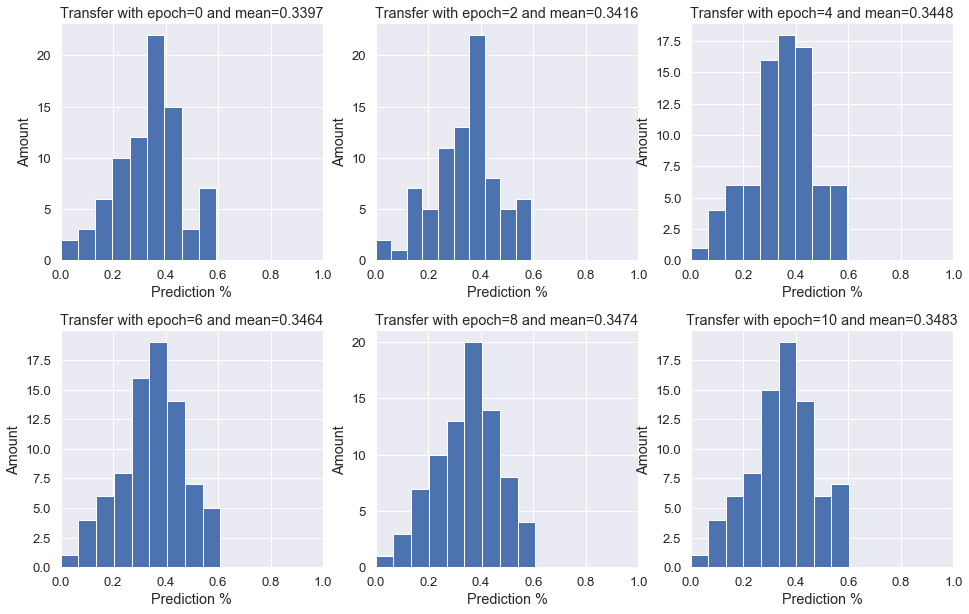

In [30]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(2,3,figsize=(16, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
labels = list(range(0,total_epoch+epochs_trans,epochs_trans))
epoch_means = np.mean(tmp,axis=1)
sns.despine(f, left=True, bottom=True)
for i in range(len(tmp)-1):
    sns.distplot(tmp[i],ax=ax[i//3,i%3],kde=False,hist_kws={"alpha": 1})
    ax[i//3,i%3].set_title(f'Transfer with epoch={labels[i]} and mean={epoch_means[i]:4.4f}')
    ax[i//3,i%3].set(xlim=(0,1.0))
    ax[i//3,i%3].set(xlabel="Prediction %", ylabel="Amount")
f.savefig(r'D:\Dropbox\Peter_Dropbox\Apps\ShareLaTeX\Master Thesis\graphics\transfer_test.eps', format='eps', dpi=300)
#f.tight_layout()
plt.show()